# Project Milestone One: Gathering your Team, Understanding the Problem,  Exploring the Data

## Due: Midnight on March 30 (with 2-hour grace period) and worth 25 points





### What We Will Do in This Milestone Assignment

1. You will convene your team (listed on Blackboard) and fill out the Team Contract (in the Homework Repo), to be submitted to Gradescope.
2. You must select a team leader for the purpose of submitting this notebook, after the team collaborates to complete the assignment. The team leader should upload the notebook and then create a group on GS for the group submission.
3. At the conclusion of your work on this Milestone, you will complete an Individual Evaluation of your team's work (in the Homework Repo) and upload it *individually* to Gradescope.
4. We will follow a simplified version of the **Machine Learning Project Checklist** in Appendix A in our textbook *Hands-On Machine Learning* (pp.779):  

>Part 1:	Frame the problem and look at the big picture  
Part 2: Download and perform preliminary exploration of the data  
Part 3: Clean the Data: Drop, Impute, and Encode   
Part 4: Explore Feature Relationships  
Part 5: Investigate Feature Engineering options to better expose the underlying data patterns  

### The Dataset

All teams will use the same dataset. It is a smaller version of the Zillow housing dataset that was used in the
Zillow Million Dollar Prize which ran on Kaggle in 2017 (sorry, the contest is closed, so you can't win any money
with this project!).  We will try to predict the assessed tax value (`'taxvaluedollarcnt'`) of the property from a large collection
of descriptors. Some features are closely related and some are obviously useless.  There are potential outliers and also quite a few missing values. 

This is a good example of a dataset which has not been predigested for you on Kaggle, and should give you a good chance to
try all the various tools in your toolbox!


In [1]:
# =============================
# Useful Imports
# =============================

# Standard Libraries
import os
import time
import math
import io
import zipfile
import requests
from urllib.parse import urlparse
from itertools import chain, combinations

# Data Science Libraries
import numpy as np
import pandas as pd
import seaborn as sns

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as mticker  # Optional: Format y-axis labels as dollars

# Scikit-learn (Machine Learning)
from sklearn.model_selection import (
    train_test_split, 
    cross_val_score, 
    GridSearchCV, 
    RandomizedSearchCV, 
    RepeatedKFold
)
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector, f_regression, SelectKBest
from sklearn.datasets import make_regression
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor

# Kaggle and Progress Tracking
import kagglehub
from tqdm import tqdm

# =============================
# Global Variables
# =============================
random_state = 42

# =============================
# Utility Functions
# =============================

# Format y-axis labels as dollars with commas (optional)
def dollar_format(x, pos):
    return f'${x:,.0f}'

# Convert seconds to HH:MM:SS format
def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))



## Prelude: Download the Zillow Housing Dataset 

The code cell below will load the dataset for you.    

> **Notice that before downloading, this cell first checks whether the files already exist.** 

For a detailed description of the dataset features, please refer to  **Appendix 1** below. 

**Note:** Do **not** perform a train/test split for this milestone (unlike HOML suggests), since you need to do the split **after** any data preparation and feature engineering. You can wait until Milestone 2 to do the split. 

In [2]:

url = "https://www.cs.bu.edu/fac/snyder/cs505/Data/zillow_dataset.csv"

filename = os.path.basename(urlparse(url).path)

if not os.path.exists(filename):
    try:
        print("Downloading the file...")
        response = requests.get(url)
        response.raise_for_status()  # Raise an error for bad status codes
        with open(filename, "wb") as f:
            f.write(response.content)
        print("File downloaded successfully.")
    except requests.exceptions.RequestException as e:
        print(f"Error downloading the file: {e}")
else:
    print("File already exists. Skipping download.")

df = pd.read_csv(filename)

File already exists. Skipping download.


## Part 1: Frame the problem and look at the big picture [3 pts]

This part is a bit vague, since this project is not taking place in an actual business, but for the sake of exercizing all the steps, **pretend** that you are working at Zillow as a data analyst and are given this dataset and asked to
- Analyze and understand the data; 
- Create a regression model;
- Give a presentation to the marketing team about your results.  

#### **1 Discussion:** 

AFTER doing your EDA, come back and answer each of the following 3 questions in a *concise and informative paragraph between the lines;* you may wish to use your own business or home-buying experience, or to do some online research about the issues before you propose your ideas. (Don't stress about this, but *humor your professor and give it your best shot!*)


**1.1:**  What is the objective of this project in business terms?


**Answer**: The objective of this project, in business terms, is to improve Zillow's ability to estimate property values by predicting the tax-assessed value using available property characteristics. A more accurate understanding of a home's estimated value allows Zillow to refine pricing tools like the Zestimate, better match buyers with properties, and offer more relevant insights to homeowners, real-estate agents and advertisers. In addition, this can help realtors using Zillow predict more accurately changes in the tax-assessed value of houses. The tax-assessed value of the house will not fluctuate as much as the market value; however, changes could alert realtors to local policy, economy, or tax rule adjustments. 

**1.2:**  How will your solution be used?


**Answer**:
How our solution will be used is a regression model trained on features like square footage, number of rooms, number of bathrooms, and location. This can be used by marketing teams to identify undervalued or high potential homes in specific regions. It can also support targeted campaigns, such as promoting listings with favorable value to feature rations. This will offer insight to sellers and buyers about how specific home features impact house value and help answer questions such as what features are most important when determining the tax value of a house and what makes a house more valuable upon assessment. This could also help potential buyers track their own home value accurately on the zillow website and look for potential homes within their price range. Improving the accuracy of the prediction also improves Zillow's reputation as a company.

**1.3:**  How should success (or failure) be measured?


**Answer**:
Success should be measured by the model's predicitive accuracy, but also by how actionable and interpretable the results are for non-technical teams and by how well the model generalizes to unseen data. If the model can help surface valuable properties, drive user engagement, and increase click-through rates on listings or ads, that would represent clear business value. Failure would mean the model is too inaccurate or too complex to be applied meaningfully across Zillow's Platform. Some indicators of failure might be poor performance, overfitting or underfitting issues, and bad preprocessing choices that introduce too much bias.

## Part 2: Download and perform preliminary exploration of the data [4 pts]

### Part 2.A: Load the data into a dataframe and study each feature/column and its characteristics:
- Name
- Type (categorical, int/float, text, etc.)
- Apparent usefulness for the task
- Approximate % of missing values
- How many unique values

**Note:** The **target** is the last column `'taxvaluedollarcnt'` -- pay particular attention to this during the EDA process. 
  
Hint: Just use `.head()`, `.info()`, and `.nunique()`.

In [3]:
df.head()

parcelid  airconditioningtypeid  architecturalstyletypeid  basementsqft  \
0  14297519                    NaN                       NaN           NaN   
1  17052889                    NaN                       NaN           NaN   
2  14186244                    NaN                       NaN           NaN   
3  12177905                    NaN                       NaN           NaN   
4  10887214                    1.0                       NaN           NaN   

   bathroomcnt  bedroomcnt  buildingclasstypeid  buildingqualitytypeid  \
0          3.5         4.0                  NaN                    NaN   
1          1.0         2.0                  NaN                    NaN   
2          2.0         3.0                  NaN                    NaN   
3          3.0         4.0                  NaN                    8.0   
4          3.0         3.0                  NaN                    8.0   

   calculatedbathnbr  decktypeid  ...  yardbuildingsqft17  yardbuildingsqft26  \
0                3.5         NaN  ...                 NaN                 NaN   
1                1.0         NaN  ...                 NaN                 NaN   
2                2.0         NaN  ...                 NaN                 NaN   
3                3.0         NaN  ...                 NaN                 NaN   
4                3.0         NaN  ...                 NaN                 NaN   

   yearbuilt  numberofstories  fireplaceflag  assessmentyear  \
0     1998.0              NaN            NaN          2016.0   
1     1967.0              1.0            NaN          2016.0   
2     1962.0              1.0            NaN          2016.0   
3     1970.0              NaN            NaN          2016.0   
4     1964.0              NaN            NaN          2016.0   

   taxdelinquencyflag  taxdelinquencyyear  censustractandblock  \
0                 NaN                 NaN         6.059063e+13   
1                 NaN                 NaN         6.111001e+13   
2                 NaN                 NaN         6.059022e+13   
3                 NaN                 NaN         6.037300e+13   
4                 NaN                 NaN         6.037124e+13   

   taxvaluedollarcnt  
0          1023282.0  
1           464000.0  
2           564778.0  
3           145143.0  
4           119407.0  

[5 rows x 55 columns]

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77613 entries, 0 to 77612
Data columns (total 55 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      77613 non-null  int64  
 1   airconditioningtypeid         25007 non-null  float64
 2   architecturalstyletypeid      207 non-null    float64
 3   basementsqft                  50 non-null     float64
 4   bathroomcnt                   77579 non-null  float64
 5   bedroomcnt                    77579 non-null  float64
 6   buildingclasstypeid           15 non-null     float64
 7   buildingqualitytypeid         49809 non-null  float64
 8   calculatedbathnbr             76963 non-null  float64
 9   decktypeid                    614 non-null    float64
 10  finishedfloor1squarefeet      6037 non-null   float64
 11  calculatedfinishedsquarefeet  77378 non-null  float64
 12  finishedsquarefeet12          73923 non-null  float64
 13  f

In [5]:
df.nunique()

parcelid                        77414
airconditioningtypeid               5
architecturalstyletypeid            5
basementsqft                       43
bathroomcnt                        22
bedroomcnt                         16
buildingclasstypeid                 2
buildingqualitytypeid              12
calculatedbathnbr                  21
decktypeid                          1
finishedfloor1squarefeet         1787
calculatedfinishedsquarefeet     4972
finishedsquarefeet12             4868
finishedsquarefeet13               13
finishedsquarefeet15             1724
finishedsquarefeet50             1807
finishedsquarefeet6               350
fips                                3
fireplacecnt                        5
fullbathcnt                        13
garagecarcnt                       14
garagetotalsqft                   839
hashottuborspa                      1
heatingorsystemtypeid              10
latitude                        64038
longitude                       62461
lotsizesquar

In [6]:
df['taxvaluedollarcnt'].describe()

count    7.757800e+04
mean     4.901506e+05
std      6.537979e+05
min      1.000000e+03
25%      2.068985e+05
50%      3.588785e+05
75%      5.690000e+05
max      4.906124e+07
Name: taxvaluedollarcnt, dtype: float64

In [7]:
# This function will list how many nulls occur in which features and save the counts, percentages, and feature types

def save_null_counts_features(df):
    # Count the nulls and calculate the %
    count_nulls = df.isnull().sum()
    df_nulls = (df.isnull().mean() * 100).round(2)
    
    # Determine if the column is numeric or non-numeric
    feature_types = df.dtypes.apply(lambda x: 'Numeric' if np.issubdtype(x, np.number) else 'Categorical')
    
    # Filter out the columns with missing values and sort them in descending order
    missing_data = pd.DataFrame({
        'Feature': count_nulls[count_nulls > 0].index,
        '# Null Values': count_nulls[count_nulls > 0].values, 
        'Null %': df_nulls[df_nulls > 0].values,
        'Type': feature_types[count_nulls > 0].values
    }).sort_values(by='Null %', ascending=False)
    
    print(f'The dataset contains {len(df)} samples.\n')

    if (len(missing_data) == 0):
        print("There are no null values in the dataset!")
    else:
        # Print null value stats
        print(f"{'Feature Name':<25} | {'# Nulls':<10} | {'Null %':<10} | {'Type'}")
        print('-' * 26, '-' * 12, '-' * 12, '-' * 12)
        for index, row in missing_data.iterrows():
            print(f"{row['Feature']:<25} | {row['# Null Values']:<10} | {row['Null %']:.2f}%{'':<4} | {row['Type']}")
    return count_nulls, df_nulls, feature_types

count_nulls, df_null_percentage, feature_types = save_null_counts_features(df)

The dataset contains 77613 samples.

Feature Name              | # Nulls    | Null %     | Type
-------------------------- ------------ ------------ ------------
buildingclasstypeid       | 77598      | 99.98%     | Numeric
finishedsquarefeet13      | 77571      | 99.95%     | Numeric
basementsqft              | 77563      | 99.94%     | Numeric
storytypeid               | 77563      | 99.94%     | Numeric
yardbuildingsqft26        | 77543      | 99.91%     | Numeric
fireplaceflag             | 77441      | 99.78%     | Categorical
architecturalstyletypeid  | 77406      | 99.73%     | Numeric
typeconstructiontypeid    | 77390      | 99.71%     | Numeric
finishedsquarefeet6       | 77227      | 99.50%     | Numeric
pooltypeid10              | 77148      | 99.40%     | Numeric
decktypeid                | 76999      | 99.21%     | Numeric
poolsizesum               | 76744      | 98.88%     | Numeric
pooltypeid2               | 76539      | 98.62%     | Numeric
hashottuborspa            | 

In [8]:
# Which features are categorical?
print('List of non-numeric columns:')
feature_types[feature_types == 'Categorical']

List of non-numeric columns:


hashottuborspa               Categorical
propertycountylandusecode    Categorical
propertyzoningdesc           Categorical
fireplaceflag                Categorical
taxdelinquencyflag           Categorical
dtype: object

In [9]:
# Which features appear useless because of the percentage of missing values?
print('List of features with more than 50% null values:')
df_null_percentage[df_null_percentage > 50].sort_values(ascending=False)

List of features with more than 50% null values:


buildingclasstypeid         99.98
finishedsquarefeet13        99.95
basementsqft                99.94
storytypeid                 99.94
yardbuildingsqft26          99.91
fireplaceflag               99.78
architecturalstyletypeid    99.73
typeconstructiontypeid      99.71
finishedsquarefeet6         99.50
pooltypeid10                99.40
decktypeid                  99.21
poolsizesum                 98.88
pooltypeid2                 98.62
hashottuborspa              98.02
yardbuildingsqft17          96.92
taxdelinquencyyear          96.26
taxdelinquencyflag          96.26
finishedsquarefeet15        96.10
finishedsquarefeet50        92.22
finishedfloor1squarefeet    92.22
fireplacecnt                89.32
threequarterbathnbr         86.98
pooltypeid7                 80.57
poolcnt                     79.16
numberofstories             77.32
airconditioningtypeid       67.78
garagetotalsqft             67.12
garagecarcnt                67.12
regionidneighborhood        60.09
dtype: float64

In [10]:
# Which features appear useless because of the number of unique values?
unique_counts = df.nunique().sort_values()
print('Top 20 Lowest Unique Count Values:')
print(unique_counts.head(20))

Top 20 Lowest Unique Count Values:
poolcnt                     1
storytypeid                 1
pooltypeid7                 1
pooltypeid2                 1
pooltypeid10                1
fireplaceflag               1
hashottuborspa              1
decktypeid                  1
taxdelinquencyflag          1
assessmentyear              1
buildingclasstypeid         2
regionidcounty              3
fips                        3
numberofstories             4
typeconstructiontypeid      4
threequarterbathnbr         4
airconditioningtypeid       5
architecturalstyletypeid    5
fireplacecnt                5
unitcnt                     8
dtype: int64


In [11]:
print(df.attrs)

{}


#### **2.A Discussion:** Answer the following questions.

**2.A.1:**  Which features are categorical?

Non-Numeric Data Types:
* hashottuborspa
* propertycountylandusecode
* propertyzoningdesc
* fireplaceflag
* taxdelinquencyflag

Categorical could also refer to whether the values are measuring a quantity or sorting into distinct categories. In this case, all the features with id would also be categorical even though they are represented with numbers. According to ChatGPT, FIPS is a numerical code that identifies geographical regions in the real-estate industry, so this feature as well as year built would also be categorical.

**2.A.2:**  Are there any features which appear at first glance to be **useless** for the business purpose of this project and should be deleted?  Give examples and describe your reasoning briefly. 

List of Useless Features:
* parcelid - unique ID for each property, won't help in predicting value 
* censustractandblock - unique geographic code, too specific
* hashottuborspa - if nunique shows only 1 value, mostly nulls, not informitive
* rawcensustractandblock - too general for predictive power
* assessmentyear - might affect selling rate, but probably would not affect the actual tax-assessed price

**2.A.3:**  Are there any features which appear to be **useless** because of the percentage of missing values?  If so, give an example. 

Top 10 features with the most null values:
- buildingclasstypeid
- finishedsquarefeet13
- basementsqft
- storytypeid
- yardbuildingsqft26
- fireplaceflag
- architecturalstyletypeid
- typeconstructiontypeid
- finishedsquarefeet6
- pooltypeid10

All of the examples above are greater than 90% null values. To handle these, the features with more than 90% null values should be removed since data is too sparse. Some causes for high null percentage in this particular dataset might be that the feature represents a luxury characteristic like a garage or fireplace that are not common or there was an issue collecting or recording the data

**2.A.4:**  Are there any features which appear to be **useless** because of the number of unique values?  If so, give an example. 

Features with Only 1 Unique Value:
* decktypeid
* hashottuborspa
* poolcnt
* pooltypeid10
* pooltypeid2
* pooltypeid7
* storytypeid
* fireplaceflag
* assessmentyear
* taxdelinquencyflag

These will not by useful because there is a lack of information. We can't filter out features with 2 or more because these could be potentially valuable categorical information.

### Part 2.B: Exploratory Data Analysis (EDA) -- Feature-Level Visualization  

- To get an overview, generate histograms for all features using `df.hist()`  (Hint: increase the figsize and set the layout to `(-1,m)` to get  `m` columns and as many rows as necessary.)
- Generate individual visualizations for the **target and three (3)** other interesting-looking features in the dataset (i.e., a total of 4):  
    - Use appropriate plot types (e.g., histograms and boxplots for numerical features, bar plots for categorical features) to understand distributions and identify potential outliers for these three.
    - Use as many code cells as you need, and give comments describing what each cell does.
    - Answer the discussion question posed (you should choose 3 features for which you can say something interesting in the discussion).  

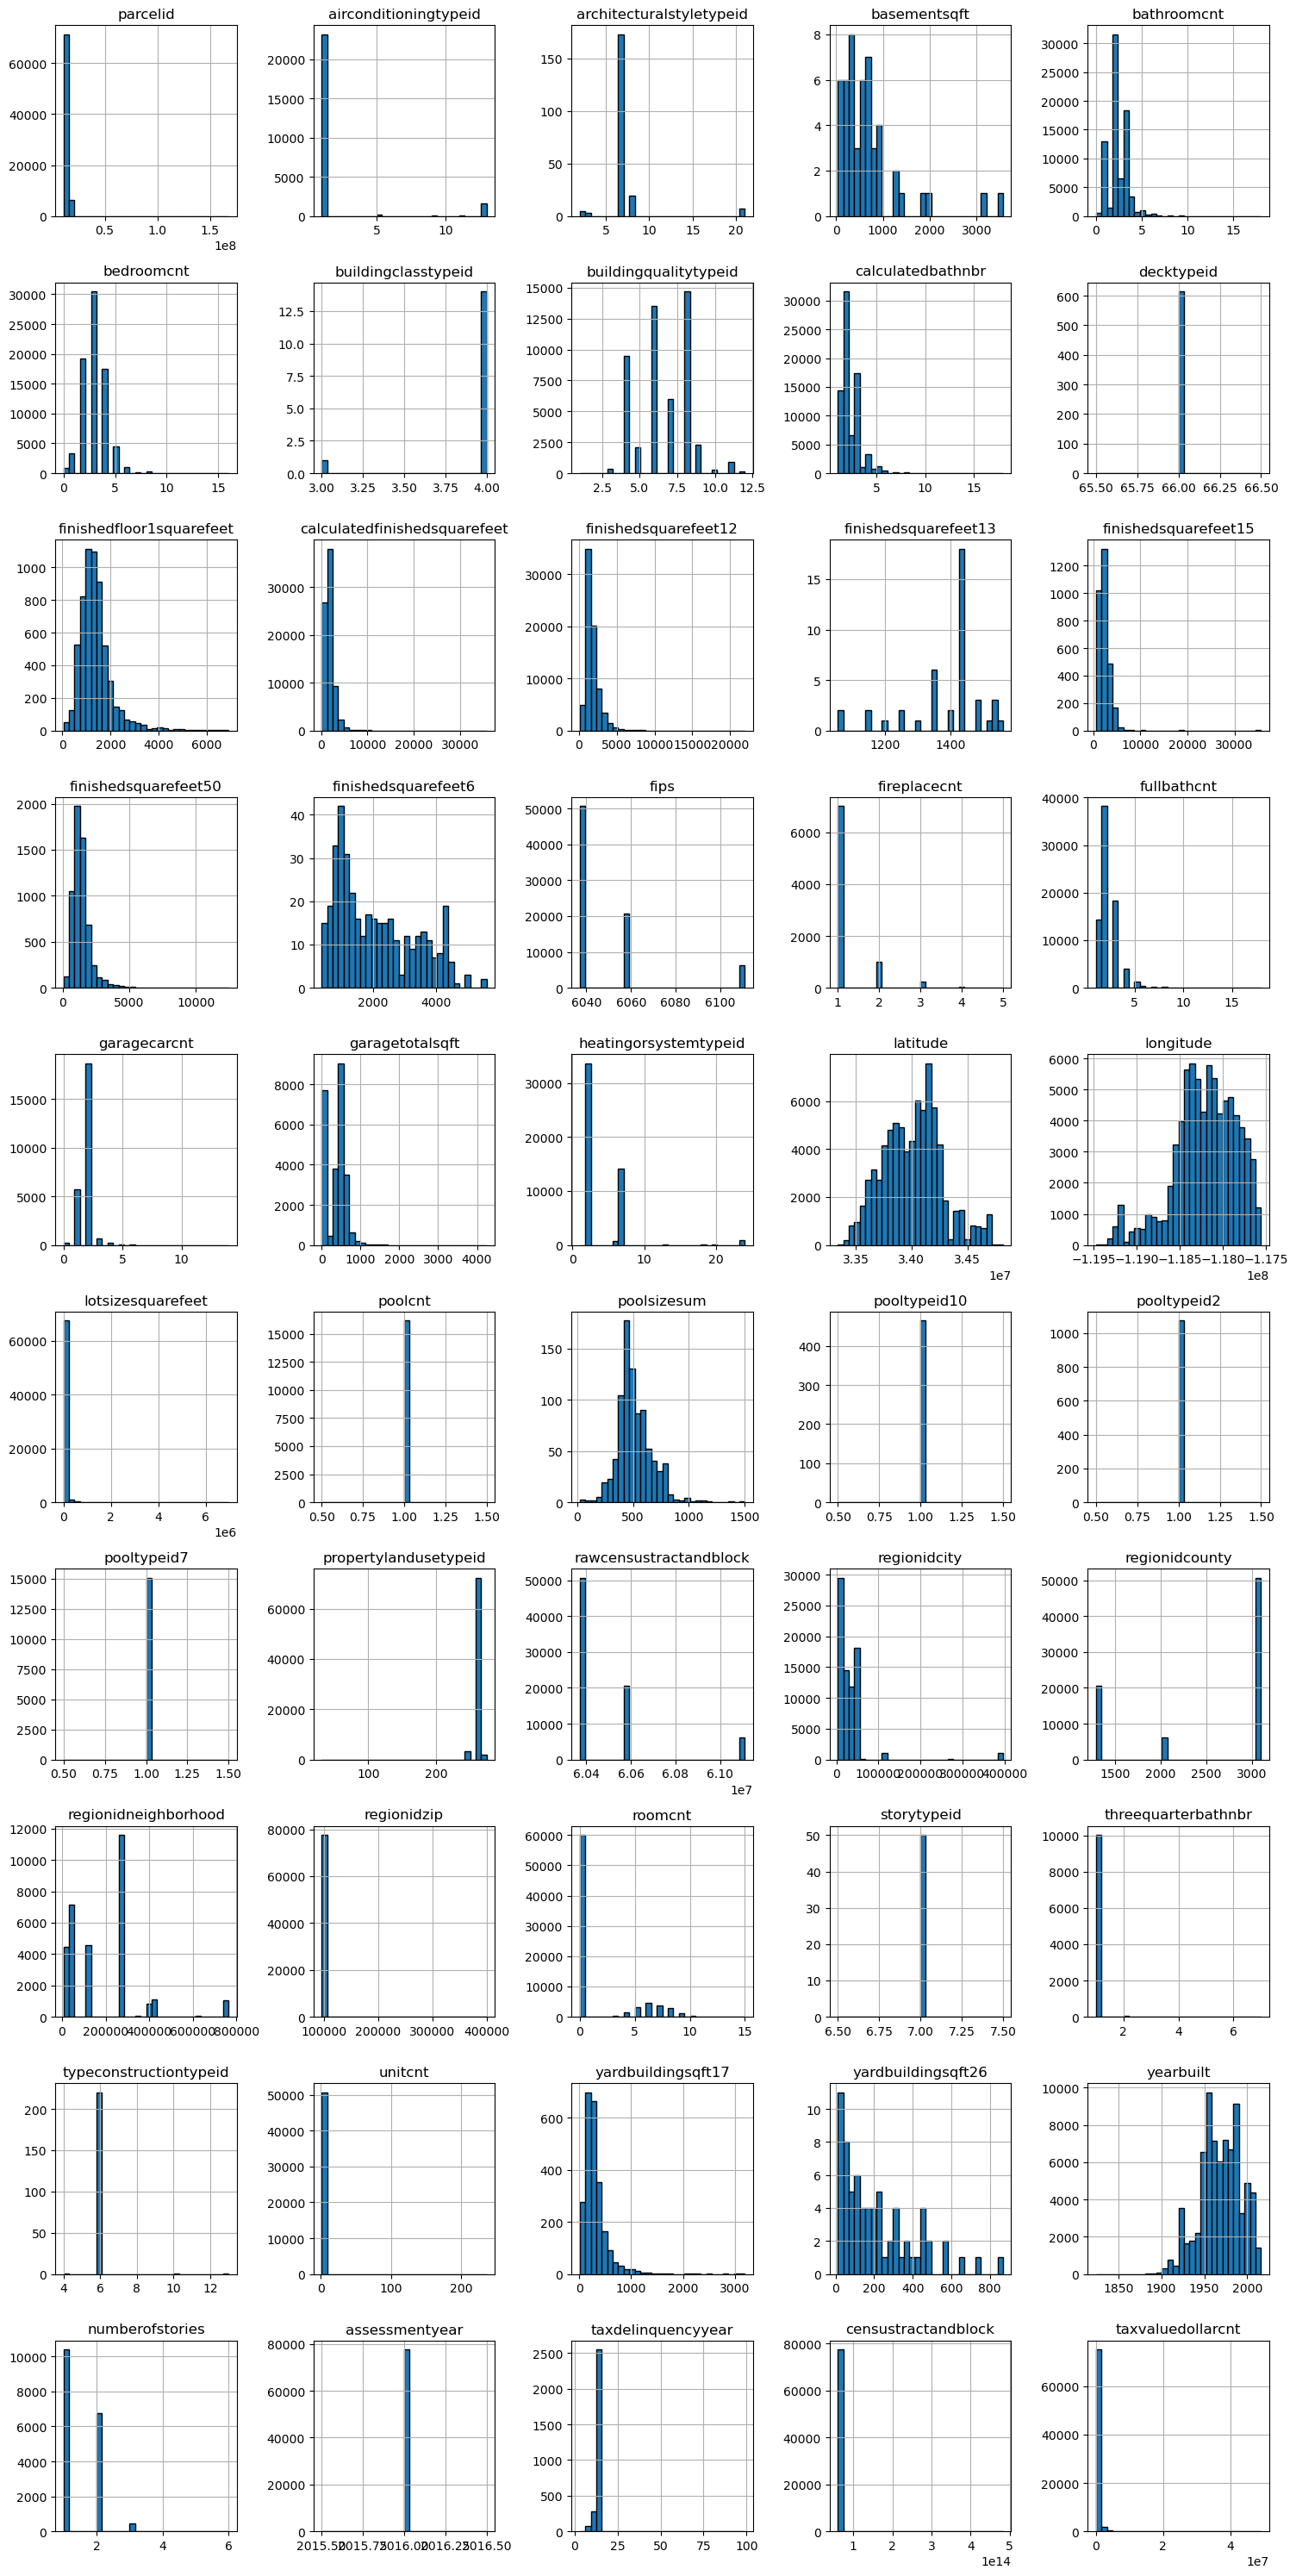

In [12]:
# Overview of features
df.hist(figsize=(15,30), layout=(-1, 5), bins=30, edgecolor='black')
plt.tight_layout()

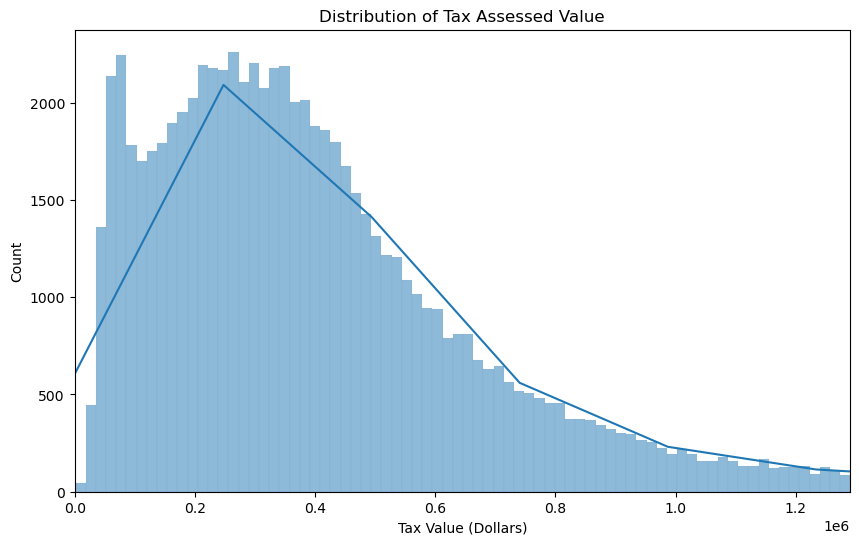

In [13]:
# Distribution of Tax Assessed Value (Target)
# Used .quantile(0.95) to zoom in and avoid being skewed by extremely high-value properties
plt.figure(figsize=(10, 6))
sns.histplot(df['taxvaluedollarcnt'], kde=True)
plt.title("Distribution of Tax Assessed Value")
plt.xlabel("Tax Value (Dollars)")
plt.ylabel("Count")
plt.xlim(0, df['taxvaluedollarcnt'].quantile(0.95))
plt.show()

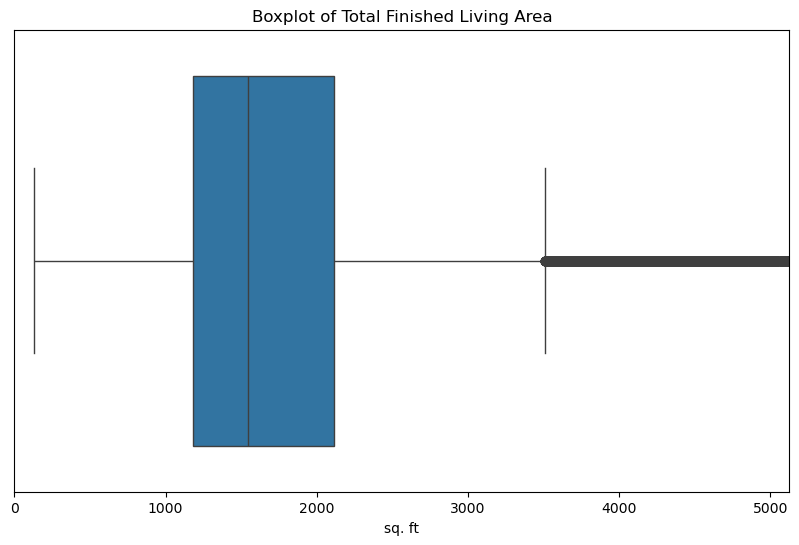

In [14]:
# Interesting Feature 1: Calculated Finished Square Footage
# A Boxplot can help us see potential outliers. We can see which properties have unusually large living areas. This features likely correlates with property value. 
plt.figure(figsize=(10, 6))
ax = sns.boxplot(x=df['calculatedfinishedsquarefeet'])
ax.set_title('Boxplot of Total Finished Living Area')
ax.set_yticks([])
ax.set_xlabel('sq. ft')
ax.set_xlim(0, df['calculatedfinishedsquarefeet'].quantile(0.99))
None

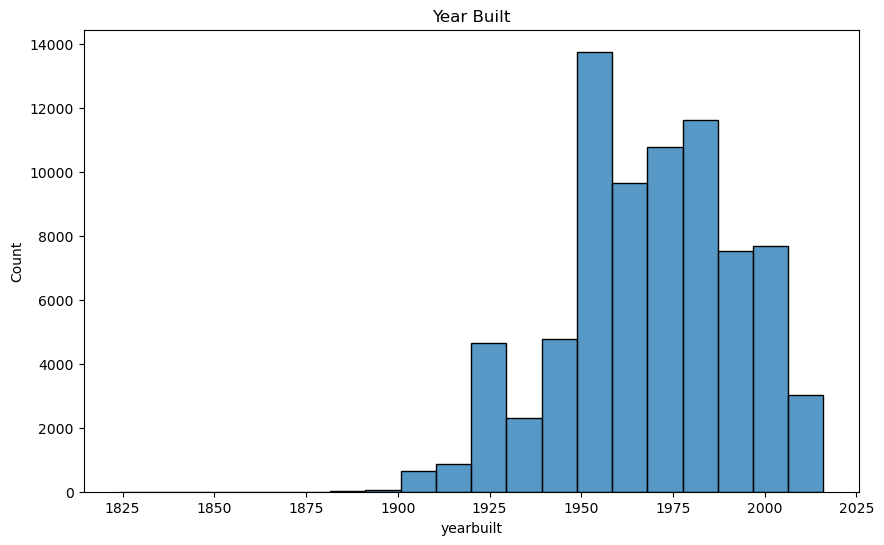

In [15]:
# Interesting Feature 2: Year Built
# This shows the distribution of the years the houses were built.
plt.figure(figsize=(10, 6))
ax = sns.histplot(x=df['yearbuilt'], bins=20)
ax.set_title('Year Built')
plt.show()

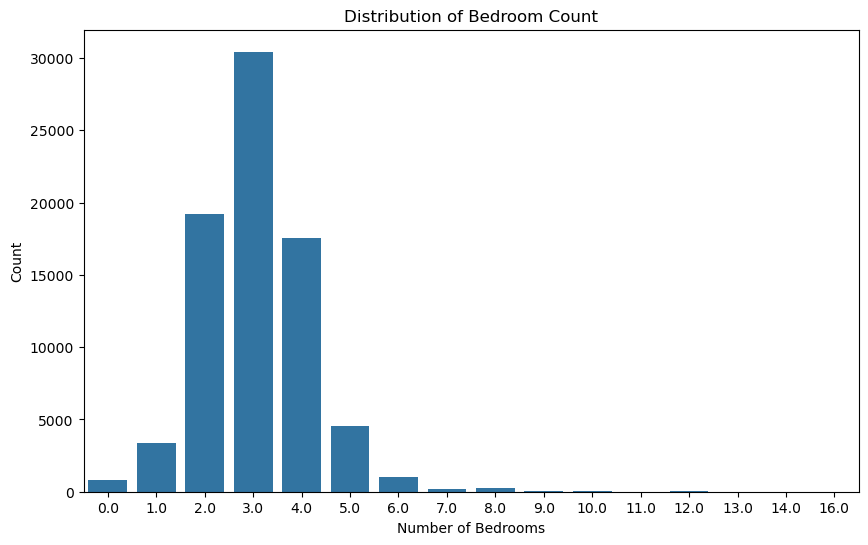

In [16]:
# Interesting Feature 3: Bedroom Count
# A count plot is ideal for small integers like bedroom counts. This shows what is typical and which values might be rare. 
plt.figure(figsize=(10, 6))
sns.countplot(x=df['bedroomcnt'])
plt.title("Distribution of Bedroom Count")
plt.xlabel("Number of Bedrooms")
plt.ylabel("Count")
plt.show()

#### **2.B Discussion:** Describe in a paragraph what you learned in your detailed examination of the features you explored:
- What is the distribution (normal, exponential, etc.) if any?
- Any problems (e.g., outliers, any odd characteristics)?
- Anything else interesting? Why did you choose it?


**Answer**:
After our examination of the target variable taxvaluedollarcnt, we determined that the distribution is heavily right-skewed showing that houses under a million dollars are more common. A small number of very high-value properties stretch the tail far to the right, indicating that scaling or transformation (like log scaling) may be needed to reduce the influence of outliers in the regression model. Another interesting characteristic is that the number of houses drops significantly for tax values under $100,000.

For our examination of the features, we started by creating a box plot of total finished living area meaasured in square feet, which revealed a wide range in home sizes and several large outliers. This feature is intuitive, widely available across listings, and directly tied to property value — making it a strong candidate for prediction. The distibution is right-skewed revealing that the majority of houses in this dataset are under 3,500 square feet. Next, we explored the distribution of bedroom count, which was unimodal and fairly symmetric, centered around 3 bedrooms, but with a slight skew toward larger homes. Finally, we looked at the distribution for year built. The data is left-skewed which makes sense since older homes would be less common. The data has a good variety of house ages mostly falling into the range 1925 to 2000.

## Part 3:  Clean the Data: Drop, Impute, and Encode [6 pts]



**Important Notes:**
- You should review your Homework 4 before doing this section!
- Create new names for modified data at each stage to avoid problems with global variables.
- Whenever possible, write functions for all data transformations you apply, for these reasons:
    - So you can easily prepare the data the next time you get a fresh dataset
    - So you can apply these transformations in future projects
    - To clean and prepare new data instances once your solution is live
    - To make it easy to treat your preparation choices as hyperparameters
    - [To apply the same transformations to your test set if train/test split already done -- not applicable here]

### Part 3.A: Drop features you judge to be unsuitable for the regression task

Your call, based on any research you can do to understand the feature (hopefully IRL you would have a domain expert to help with this, but do your best).   

Note: Do not drop features because of too many missing values, that's the next task! 

In [17]:
# This function takes a list of column names and dataframe, drops them, and returns a copy of the cleaned dataframe
def drop_useless_features(df, cols):
    df_clean = df.drop(columns=cols).copy()
    if len(df_clean.columns) < len(df.columns):
        print('Drop successful!')
    else:
        print('Drop unsuccessful.')
    return df_clean

In [18]:
# Drop the features that are not useful for regression
useless_cols = ['parcelid',
                'propertycountylandusecode',
                'propertyzoningdesc',
                'rawcensustractandblock',
                'censustractandblock',
                'taxdelinquencyflag',
                'regionidzip',
                'regionidneighborhood']

df_clean = drop_useless_features(df, useless_cols)

Drop successful!


#### **3.A Discussion:** Justify in a paragraph your decisions about which features to drop. 


In reviewing the features of the Zillow dataset, we identified several columns that can be dropped because they offer little to no predictive value for the target variable, taxvaluedollarcnt. The parcelid column is a unique identifier for each property and does not contribute to modeling. Columns like propertyzoningdesc, propertycountylandusecode, and taxdelinquencyflag are either complex text fields or low-variance categorical flags that would require extensive cleaning or offer minimal insight. Features such as regionidzip and regionidneighborhood are numeric codes that behave more like identifiers than meaningful geographic groupings, and would require additional transformation to be useful. Similarly, the features rawcensustractandblock and censustractandblock are long, unstructured geographic codes that are difficult to interpret or apply meaningfully in a regression model. Removing these features helps simplify the dataset and reduce noise in the model.

### Part 3.B: Drop **features** with "too many" null values

Your code in the next cell(s). Make a judgement call about what "too many" means and briefly describe your reasoning in the discussion.   

Note: "Too many" may depend on what the non-null values look like, be sure to investigate carefully. 

In [19]:
# This function will list how many nulls occur in which features

def show_null_counts_features(df):
    # Count the nulls and calculate the %
    count_nulls = df.isnull().sum()
    df_nulls = (df.isnull().mean() * 100).round(2)
    
    # Determine if the column is numeric or non-numeric
    feature_types = df.dtypes.apply(lambda x: 'Numeric' if np.issubdtype(x, np.number) else 'Categorical')
    
    # Filter out the columns with missing values and sort them in descending order
    missing_data = pd.DataFrame({
        'Feature': count_nulls[count_nulls > 0].index,
        '# Null Values': count_nulls[count_nulls > 0].values, 
        'Null %': df_nulls[df_nulls > 0].values,
        'Type': feature_types[count_nulls > 0].values
    }).sort_values(by='Null %', ascending=False)
    
    print(f'The dataset contains {len(df)} samples.\n')

    if (len(missing_data) == 0):
        print("There are no null values in the dataset!")
    else:
        # Print null value stats
        print(f"{'Feature Name':<29} | {'# Nulls':<10} | {'Null %':<10} | {'Type'}")
        print('-' * 30, '-' * 12, '-' * 12, '-' * 12)
        for index, row in missing_data.iterrows():
            print(f"{row['Feature']:<29} | {row['# Null Values']:<10} | {row['Null %']:.2f}%{'':<4} | {row['Type']}")

In [20]:
max_nulls = 0.8 * len(df_clean)     # We will drop any features with more than max_nulls missing values

# Count null values per column
count_nulls_by_col = df_clean.isnull().sum(axis=0)

# Filter out columns where null count exceeds max_nulls
filtered_col = []

for i, v in count_nulls_by_col.items():
    if v > max_nulls:
        filtered_col.append(i)
    else:
        continue

# Drop the columns
df_clean = df_clean.drop(columns=filtered_col)

# Uncomment to verify they were removed
show_null_counts_features(df_clean)

The dataset contains 77613 samples.

Feature Name                  | # Nulls    | Null %     | Type
------------------------------ ------------ ------------ ------------
poolcnt                       | 61439      | 79.16%     | Numeric
numberofstories               | 60014      | 77.32%     | Numeric
airconditioningtypeid         | 52606      | 67.78%     | Numeric
garagecarcnt                  | 52093      | 67.12%     | Numeric
garagetotalsqft               | 52093      | 67.12%     | Numeric
heatingorsystemtypeid         | 28042      | 36.13%     | Numeric
buildingqualitytypeid         | 27804      | 35.82%     | Numeric
unitcnt                       | 26910      | 34.67%     | Numeric
lotsizesquarefeet             | 8292       | 10.68%     | Numeric
finishedsquarefeet12          | 3690       | 4.75%     | Numeric
regionidcity                  | 1506       | 1.94%     | Numeric
calculatedbathnbr             | 650        | 0.84%     | Numeric
fullbathcnt                   | 650      

#### **3.B Discussion:** In a paragraph, explain your decision about which features were dropped



For this housing dataset, we decided to drop features with more than 80% missing values. While missing data doesn't always mean a feature is unusable, in this case, such a high percentage could skew the overall data and make it harder to draw reliable insights. Since we're trying to assess property tax value across a wide range of homes, we wanted to keep features that contribute meaningfully to that goal, without introducing too much noise or sparsity. We felt 80% was a good threshold for this Zillow dataset — it allowed us to keep moderately complete features while letting go of the ones that were mostly empty or too specific. Some of the features we dropped at this stage include basementsqft, decktypeid, and finishedsquarefeet13, since they were missing in most rows and wouldn't provide consistent value across the dataset.

### Part 3.C: Drop Problematic **samples** 

There could be several reasons why you might want to drop a sample:
- It has  "too many" null values 
- It has a null value in the target
- It contains outliers, especially in the target



Your code in the next cell(s). Make a judgement call about which samples should be dropped and briefly describe your reasoning in the discussion.   


In [21]:
# This function drops rows containing too many null values definied by a specific threshold
def drop_null_rows(df, threshold):
    filtered_df = df[df.isnull().sum(axis=1) / len(df.columns) < threshold]
    print(f'Total Remaining: {len(filtered_df)}')
    print(f'Dropped Samples: {len(df) - len(filtered_df)}')
    return filtered_df

In [22]:
# Drop rows that contain more than 70% nulls
threshold = 0.7
filtered_df = drop_null_rows(df_clean, threshold)

Total Remaining: 77579
Dropped Samples: 34


In [23]:
# This function drops null values from a specific column
def drop_nulls_col(df, col):
    dropna_col_df = df.dropna(subset=col)
    print(f'Total Remaining: {len(dropna_col_df)}')
    print(f'Dropped Samples: {len(df) - len(dropna_col_df)}')
    return dropna_col_df

In [24]:
# Drop null values in target
target_col = 'taxvaluedollarcnt'
dropna_target_df = drop_nulls_col(filtered_df, target_col)

Total Remaining: 77578
Dropped Samples: 1


In [25]:
# This function removes upper quantile outliers from a specific column
def drop_target_outliers(df, target_col, upper_quantile=0.99):
    upper_limit = df[target_col].quantile(upper_quantile)
    df_no_outliers = df[df[target_col] <= upper_limit]

    print(f'Total Remaining: {len(df_no_outliers)}')
    print(f'Dropped Samples: {len(df) - len(df_no_outliers)}')
    return df_no_outliers.copy()

In [26]:
# Drop outliers in the target
clean_target_df = drop_target_outliers(dropna_target_df, target_col)

Total Remaining: 76802
Dropped Samples: 776


In [27]:
rows_removed = df_clean.shape[0] - clean_target_df.shape[0]
print(f"\nTotal rows removed after all cleaning: {rows_removed}")


Total rows removed after all cleaning: 811


#### **3.C Discussion:** In a short paragraph, explain your decision about which samples were dropped


Samples that had more than 70% of the row containing null values, samples that have a null value for the target, and samples where the target variable, taxvaluedollarcnt, falls in the top 1% of values were dropped. These outliers likely represent luxury or high-end properties that are not representative of the broader housing market. Removing them allows the model to focus on more typical residential homes, which improves overall performance, reduces skew, and makes the model's predictions more interpretable and applicable to the majority of users.

### Part 3.D: Impute for the remaining missing values

Review the methods for imputation in **Appendix 2** and choose how you will impute the remainder of the missing values. Note:
- Consider whether different methods are justified for different features.
- In the next cells, apply your imputation methods to the dataset so that no null values remain after this step.
- Answer the discussion question.

In [28]:
# Make a copy of the dataframe
df_imputed = clean_target_df.copy()
show_null_counts_features(df_imputed)

The dataset contains 76802 samples.

Feature Name                  | # Nulls    | Null %     | Type
------------------------------ ------------ ------------ ------------
poolcnt                       | 61085      | 79.54%     | Numeric
numberofstories               | 59316      | 77.23%     | Numeric
airconditioningtypeid         | 52138      | 67.89%     | Numeric
garagecarcnt                  | 51489      | 67.04%     | Numeric
garagetotalsqft               | 51489      | 67.04%     | Numeric
heatingorsystemtypeid         | 27762      | 36.15%     | Numeric
buildingqualitytypeid         | 27454      | 35.75%     | Numeric
unitcnt                       | 26644      | 34.69%     | Numeric
lotsizesquarefeet             | 8221       | 10.70%     | Numeric
finishedsquarefeet12          | 3614       | 4.71%     | Numeric
regionidcity                  | 1457       | 1.90%     | Numeric
calculatedbathnbr             | 583        | 0.76%     | Numeric
fullbathcnt                   | 583      

In [29]:
# Handle special cases that have high number of missing values first
df_imputed['poolcnt'].value_counts(dropna=False)

poolcnt
NaN    61085
1.0    15717
Name: count, dtype: int64

In [30]:
# Impute fireplace count and pool count by filling in nulls with 0
fill_0_features = ['poolcnt']

df_imputed[fill_0_features] = df_imputed[fill_0_features].fillna(0)

# Verify
show_null_counts_features(df_imputed)

The dataset contains 76802 samples.

Feature Name                  | # Nulls    | Null %     | Type
------------------------------ ------------ ------------ ------------
numberofstories               | 59316      | 77.23%     | Numeric
airconditioningtypeid         | 52138      | 67.89%     | Numeric
garagecarcnt                  | 51489      | 67.04%     | Numeric
garagetotalsqft               | 51489      | 67.04%     | Numeric
heatingorsystemtypeid         | 27762      | 36.15%     | Numeric
buildingqualitytypeid         | 27454      | 35.75%     | Numeric
unitcnt                       | 26644      | 34.69%     | Numeric
lotsizesquarefeet             | 8221       | 10.70%     | Numeric
finishedsquarefeet12          | 3614       | 4.71%     | Numeric
regionidcity                  | 1457       | 1.90%     | Numeric
calculatedbathnbr             | 583        | 0.76%     | Numeric
fullbathcnt                   | 583        | 0.76%     | Numeric
yearbuilt                     | 246       

In [31]:
# Impute categorical numeric columns using the mode strategy
mode_categorical_features = ['numberofstories', 'airconditioningtypeid', 'garagecarcnt', 'heatingorsystemtypeid', 'buildingqualitytypeid', 'unitcnt']

imputer_mode = SimpleImputer(strategy='most_frequent')
df_imputed[mode_categorical_features] = imputer_mode.fit_transform(df_imputed[mode_categorical_features])

# Verify
show_null_counts_features(df_imputed)

The dataset contains 76802 samples.

Feature Name                  | # Nulls    | Null %     | Type
------------------------------ ------------ ------------ ------------
garagetotalsqft               | 51489      | 67.04%     | Numeric
lotsizesquarefeet             | 8221       | 10.70%     | Numeric
finishedsquarefeet12          | 3614       | 4.71%     | Numeric
regionidcity                  | 1457       | 1.90%     | Numeric
calculatedbathnbr             | 583        | 0.76%     | Numeric
fullbathcnt                   | 583        | 0.76%     | Numeric
yearbuilt                     | 246        | 0.32%     | Numeric
calculatedfinishedsquarefeet  | 180        | 0.23%     | Numeric


In [32]:
# Impute numeric columns using the median strategy
median_features = ['garagetotalsqft', 'lotsizesquarefeet', 'finishedsquarefeet12']

imputer_numeric = SimpleImputer(strategy='median')
df_imputed[median_features] = imputer_numeric.fit_transform(df_imputed[median_features])

# Verify
show_null_counts_features(df_imputed)

The dataset contains 76802 samples.

Feature Name                  | # Nulls    | Null %     | Type
------------------------------ ------------ ------------ ------------
regionidcity                  | 1457       | 1.90%     | Numeric
calculatedbathnbr             | 583        | 0.76%     | Numeric
fullbathcnt                   | 583        | 0.76%     | Numeric
yearbuilt                     | 246        | 0.32%     | Numeric
calculatedfinishedsquarefeet  | 180        | 0.23%     | Numeric


In [33]:
# Drop the remaining null values
df_imputed = df_imputed.dropna()

# Verify: There should be no null values
show_null_counts_features(df_imputed)

The dataset contains 74722 samples.

There are no null values in the dataset!


#### **3.D Discussion:**  Describe in a paragraph your decisions about which methods you used to impute missing values in the dataset


For imputation, we chose to use the median method for numerical features and the mode method for categorical features. Since this is a housing dataset, many of the key features — such as square footage, number of bathrooms, and tax value — tend to be right-skewed or include outliers. Using the median helps keep the central tendency of the data while being robust to those outliers, which makes it more appropriate than the mean in this context. Housing data rarely follows a perfectly normal distribution, so median imputation allows me to fill in missing values in a way that preserves the overall structure of the data without being distorted by extreme values. The mode strategy was utilized for the categorical features to keep the most popular categories consistant, note that this could lead to bias in our model. For the pool count, a new category was introduced by filling in 0 for all null values, representing no pool or unknown. This method was chosen because this feature only had 1 unique value, so a new category made more sense. For the remaining features containing less than 2% null values, we chose to drop them which could lead to lose of valuable date; however, since the percentage was so low, this method was the easiest and best option.

### 3.E: Encode the Categorical Features (if any)

You may not have any categorical features. If you do, encode them in the next step. No discussion is necessary. 

In [34]:
df_imputed.dtypes

airconditioningtypeid           float64
bathroomcnt                     float64
bedroomcnt                      float64
buildingqualitytypeid           float64
calculatedbathnbr               float64
calculatedfinishedsquarefeet    float64
finishedsquarefeet12            float64
fips                            float64
fullbathcnt                     float64
garagecarcnt                    float64
garagetotalsqft                 float64
heatingorsystemtypeid           float64
latitude                        float64
longitude                       float64
lotsizesquarefeet               float64
poolcnt                         float64
propertylandusetypeid           float64
regionidcity                    float64
regionidcounty                  float64
roomcnt                         float64
unitcnt                         float64
yearbuilt                       float64
numberofstories                 float64
assessmentyear                  float64
taxvaluedollarcnt               float64


## Part 4:  Investigate Feature Relationships  [6 pts]

In this part, we will investigate the feature relationships as a way of understanding the data.  In the next part, we'll investigate potential feature engineering opportunities.

**Note:**  We won't be committing to any changes to the data until Milestone 2, as our choice of transformations will very much depend on the model we're building. But investigating these aspects of the data is an essential step in the first stages of our project. 

### Part 4.A:

   - Compute and analyze pairwise correlations using a correlation matrix.
   - Compute the F-statistic for all features for a better view of the relationships (displaying them in a bar chart would be useful as well). 
   - Identify features with strong correlations or notable relationships that may impact model performance.
   - Investigate forward and backward feature selection
        - Run these algorithms to investigate possible feature selection (don't commit to any selections yet)

Your code below, in multiple cells with descriptive comments. 

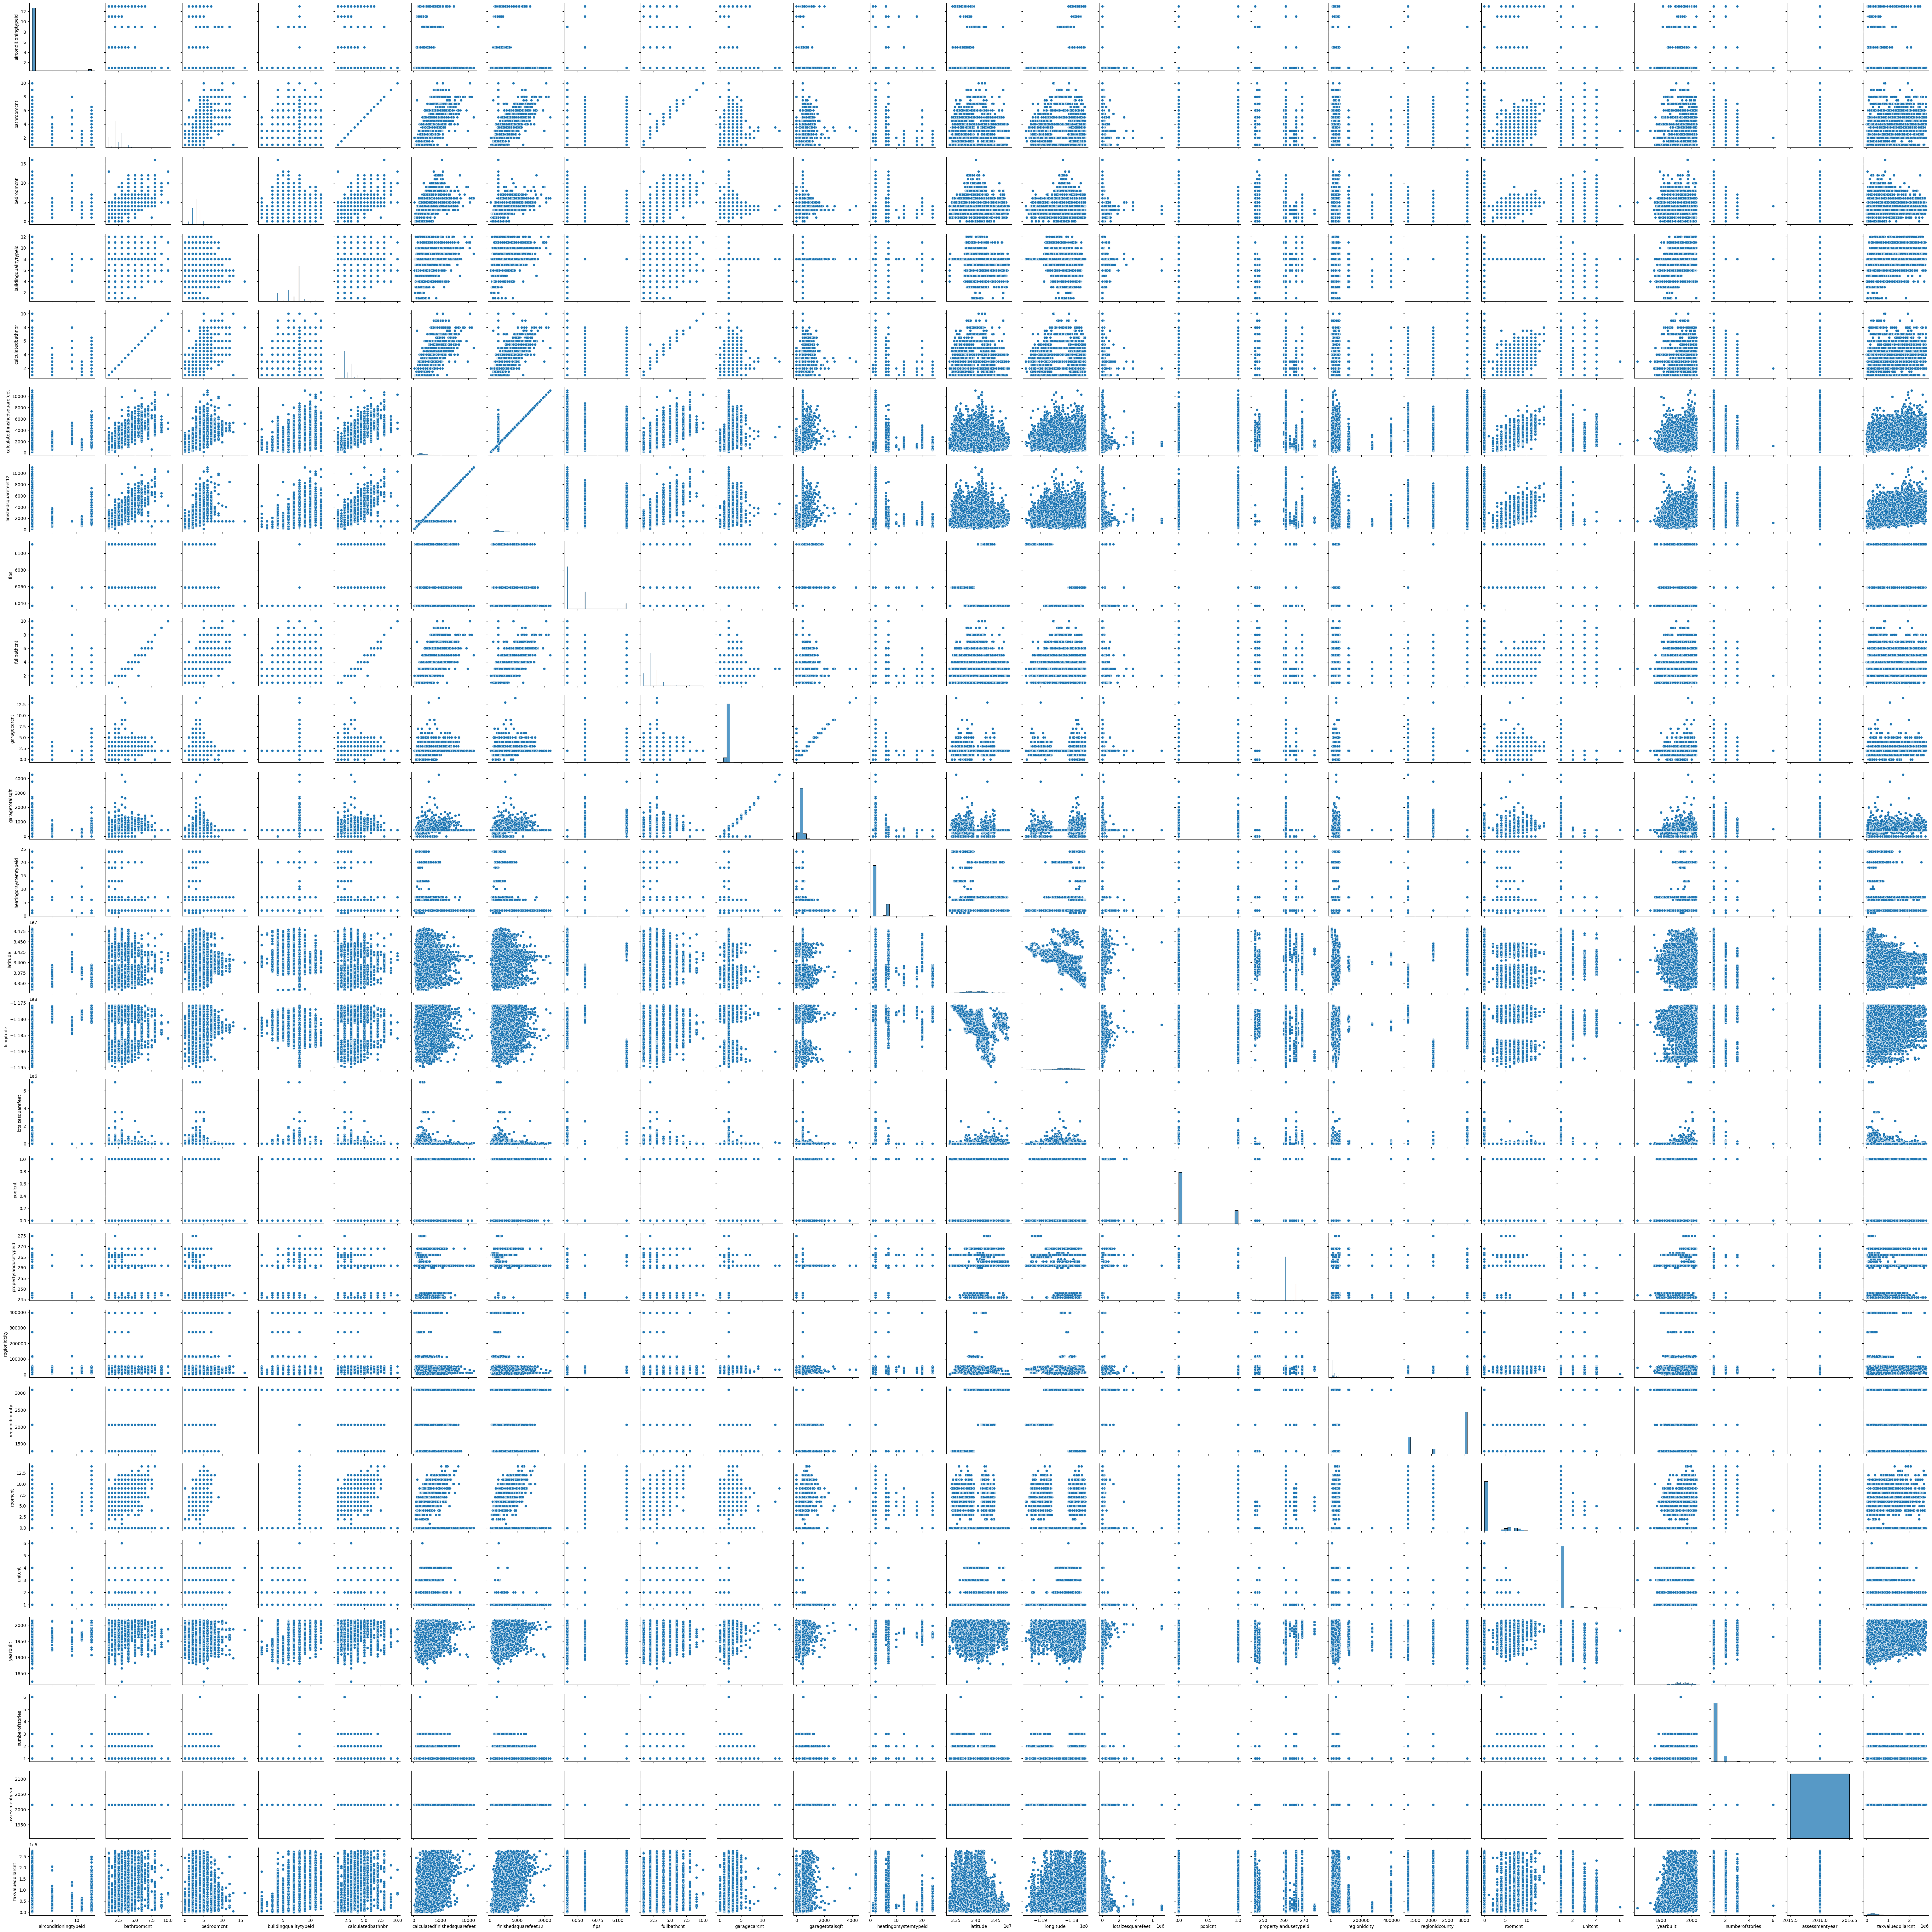

In [35]:
_ = sns.pairplot(df_imputed)

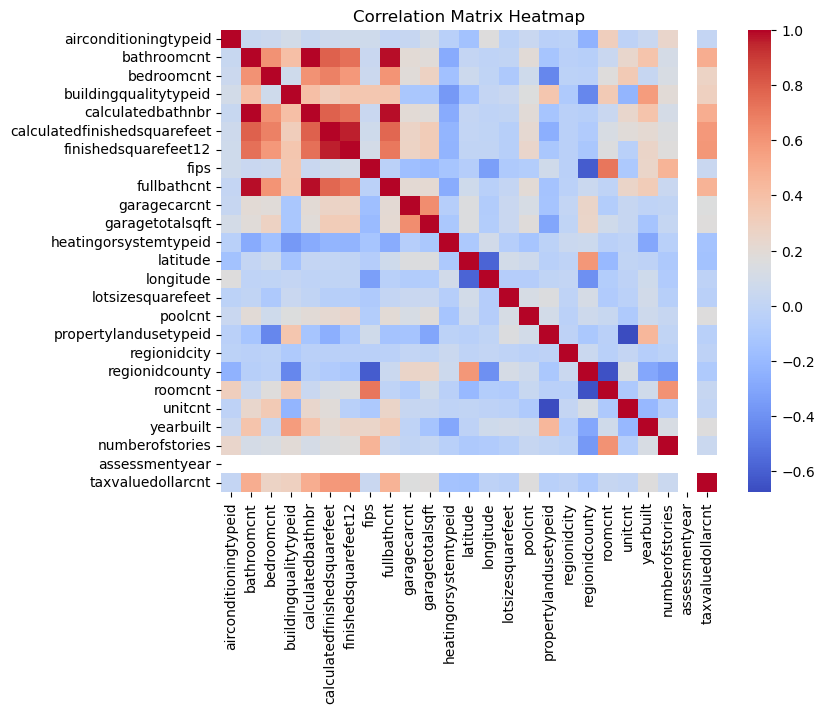

In [36]:
# Calculate and plot correlation matrix
plt.figure(figsize=(8,6))
corr_matrix = df_imputed.corr()
sns.heatmap(corr_matrix, cmap='coolwarm')
plt.title("Correlation Matrix Heatmap")
plt.show()

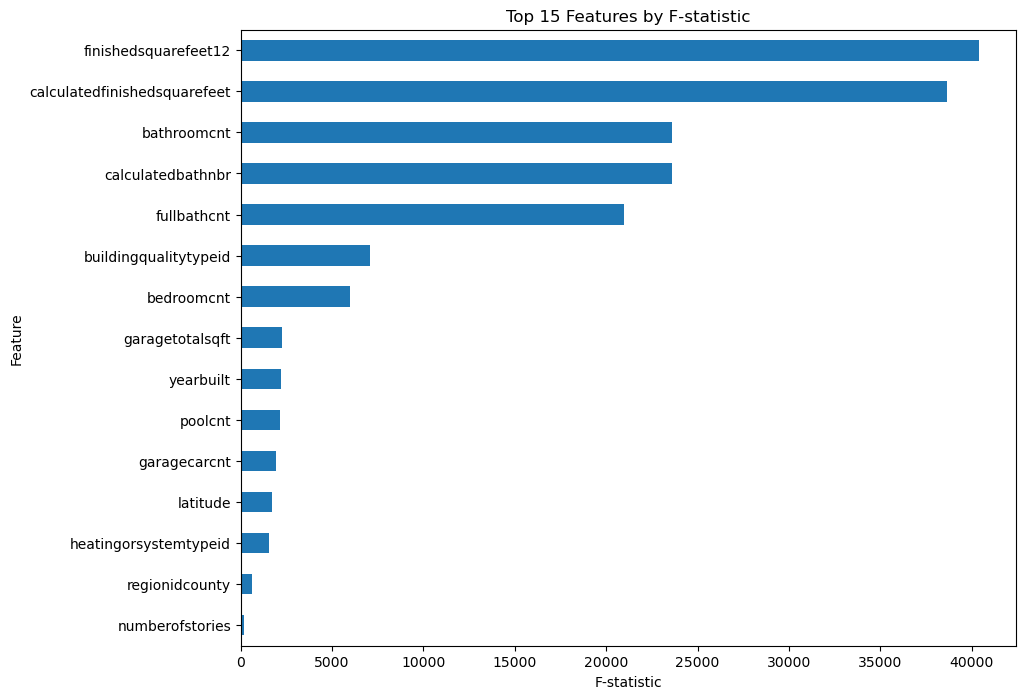

In [37]:
# Separate features and targets
df_features = df_imputed.drop(columns='taxvaluedollarcnt')
df_target = df_imputed['taxvaluedollarcnt']

# Perform F-test for feature selection (regression)
f_stat_reg, p_values_reg = f_regression(df_features, df_target)

# Display the F-statistics for each feature
f_stat_reg_df = pd.DataFrame({'Feature': df_features.columns,
                              'F-statistic': f_stat_reg,
                              'P-value': p_values_reg
                              }).sort_values(by='F-statistic', ascending=False)

# Plot top 15 features by F-score
f_stat_reg_df.head(15).plot(kind='barh', x='Feature', y='F-statistic', figsize=(10, 8), legend=False)
plt.title("Top 15 Features by F-statistic")
plt.xlabel("F-statistic")
plt.gca().invert_yaxis()
plt.show()

### Feature Selction Using SequentialFeatureSelector:

In [38]:
# Imports
from sklearn.linear_model import LinearRegression

# Separating the Feature and Target 
X = df_features
y = df_target

#Splitting into training and testing data 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Define model
model = LinearRegression()

# Forward selection 
forward_selector = SequentialFeatureSelector(model, direction='forward', scoring='r2', cv=5)
forward_selector.fit(X_train, y_train)

print("Forward-selected features:")
print(X.columns[forward_selector.get_support()])


# Backward selection
backward_selector = SequentialFeatureSelector(model, direction='backward', scoring='r2', cv=5)
backward_selector.fit(X_train, y_train)

print("Backward-selected features:")
print(X.columns[backward_selector.get_support()])

Forward-selected features:
Index(['bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid',
       'calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'fullbathcnt',
       'garagetotalsqft', 'latitude', 'longitude', 'lotsizesquarefeet',
       'roomcnt', 'yearbuilt'],
      dtype='object')
Backward-selected features:
Index(['bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid',
       'calculatedfinishedsquarefeet', 'finishedsquarefeet12',
       'garagetotalsqft', 'latitude', 'longitude', 'lotsizesquarefeet',
       'propertylandusetypeid', 'roomcnt', 'unitcnt'],
      dtype='object')


### Feature Selction Using Code from Class:

In [39]:
# Forward Feature Selection

def forward_feature_selection(X, y, model, 
                              scoring='neg_mean_squared_error', 
                              cv=5, 
                              tol=None,               # None = no delta cutoff
                                                      # use 0.0 for "no further improvements"
                                                      # and 1e-4 for "point of diminishing returns"                                      
                              max_features=None,      # None = use all features
                              n_jobs=-1,
                              verbose=False
                             ):
    selected_features = []                            # List to store the order of features selected
    remaining_features = list(X.columns)              # Features not yet selected
    best_scores = []                                  # List to store the CV score after each feature addition
    previous_score = float('inf')                     # Initialize previous score for improvement comparison

    # Track the best subset of features and its corresponding score
    
    best_feature_set = None                           # Best combination of features found so far
    best_score = float('inf')                         # Best CV score observed so far
    
    while remaining_features:
        scores = {}                                   # Dictionary to hold CV scores for each candidate feature
        for feature in remaining_features:
            current_features = selected_features + [feature]
            
            # Compute the CV score for the current set of features (negated MSE, so lower is better)
            cv_score = -cross_val_score(model, X[current_features], y, 
                                        scoring=scoring, cv=cv, n_jobs=n_jobs
                                       ).mean()
            scores[feature] = cv_score

        # Select the feature that minimizes the CV score
        best_feature = min(scores, key=scores.get)
        current_score = scores[best_feature]
            
        # Check if the improvement is significant based on the tolerance (tol)
        if tol is not None and previous_score - current_score < tol:
            if verbose:
                print("Stopping early due to minimal improvement.")
            break

        # Add the best feature to the selected list and update score trackers
        selected_features.append(best_feature)
        best_scores.append(current_score)
        remaining_features.remove(best_feature)
        previous_score = current_score

        if verbose:
            print(f"\nFeatures: {selected_features[-3:]}, CV Score (MSE): {current_score:.4f}")
        
        # Update the best subset if the current score is better than the best so far
        if current_score < best_score:
            best_score = current_score
            best_feature_set = selected_features.copy()
        
        # Check if the maximum number of features has been reached
        if max_features is not None and len(selected_features) >= max_features:
            break

    return (
        selected_features,      # List of features in the order they were selected (this will be ALL features if max_features == None
        best_scores,            # List of cross-validation scores corresponding to each addition in the previous list
        best_feature_set,       # The subset of features that achieved the best CV score.
        best_score              # The best CV score
    )


In [40]:
# Define model
model_forward = LinearRegression()

# Run forward feature selection algorithm
selected_features_forward, best_scores_forward, best_feature_set_forward, best_score_forward = forward_feature_selection(X_train, y_train, model_forward)

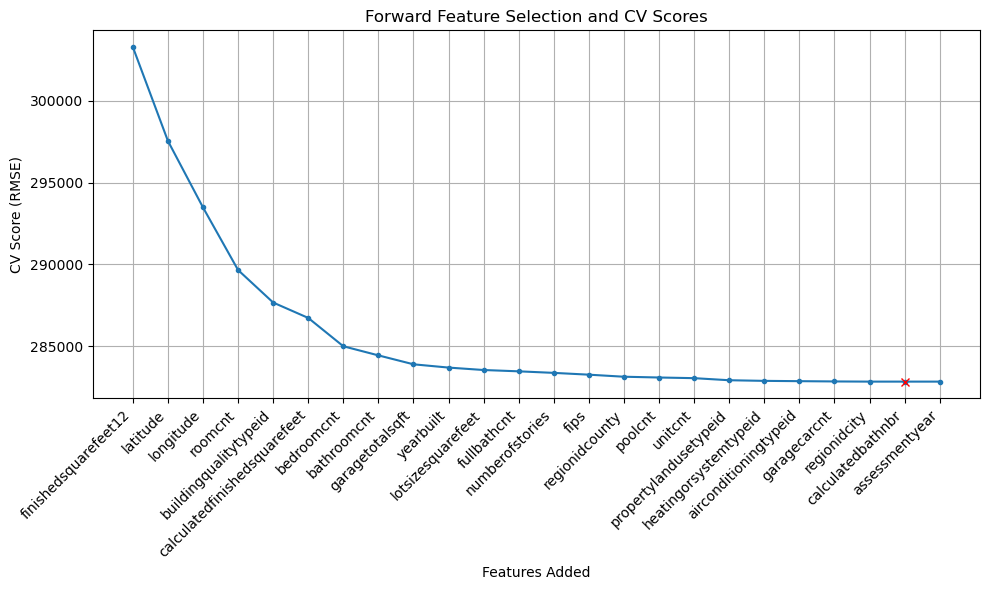

RESULTS FOR FORWARD SELECTION
Best Features: ['finishedsquarefeet12', 'latitude', 'longitude', 'roomcnt', 'buildingqualitytypeid', 'calculatedfinishedsquarefeet', 'bedroomcnt', 'bathroomcnt', 'garagetotalsqft', 'yearbuilt', 'lotsizesquarefeet', 'fullbathcnt', 'numberofstories', 'fips', 'regionidcounty', 'poolcnt', 'unitcnt', 'propertylandusetypeid', 'heatingorsystemtypeid', 'airconditioningtypeid', 'garagecarcnt', 'regionidcity', 'calculatedbathnbr']
Best CV Score (RMSE): $282,821.81


In [41]:
# Convert scores to Root MSE
best_scores_RMSE_forward = np.sqrt(best_scores_forward)
best_score_RMSE_forward = np.sqrt(best_score_forward)

# Plot the results
index = np.argmax(np.array(selected_features_forward) == best_feature_set_forward[-1])

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(best_scores_RMSE_forward) + 1), best_scores_RMSE_forward, marker='.')
plt.plot([index+1],best_score_RMSE_forward,marker='x',color='red')
plt.xticks(range(1, len(selected_features_forward) + 1), selected_features_forward, rotation=45, ha='right')
plt.title('Forward Feature Selection and CV Scores')
plt.xlabel('Features Added')
plt.ylabel('CV Score (RMSE)')
plt.grid()
plt.tight_layout()
plt.show()

# Print the best subset and score
print("RESULTS FOR FORWARD SELECTION")
print(f"Best Features: {best_feature_set_forward}")
print(f"Best CV Score (RMSE): ${best_score_RMSE_forward:,.2f}")

In [42]:
# Backward Feature Selection

def backward_feature_selection(X, y, model, 
                               scoring='neg_mean_squared_error', 
                               cv=5, 
                               tol=None,               # None = no delta cutoff
                                                       # use 0.0 for "no further improvements"
                                                       # and 1e-4 for "point of diminishing returns"                                      
                               max_features=None,      # If None, remove features until only 1 remains
                                                       # Otherwise, stop when this many features remain
                               n_jobs=-1,
                               verbose=False
                              ):
    
    # Helper function to compute CV score using LinearRegression
    def cv_score(features):
        return -cross_val_score(model, X[features], y, 
                                scoring=scoring, cv=cv, 
                                n_jobs=n_jobs          ).mean()
    
    # Start with all features (using a list for easier manipulation)
    features_remaining = list(X.columns)
    
    # Compute initial CV score with the full feature set
    initial_score = cv_score(features_remaining)
    
    # Initialize tracking variables
    best_score        = initial_score                # Best (lowest) CV score observed so far
    best_feature_set  = features_remaining.copy()    # Feature set corresponding to best_score
    selected_features = ['NONE']                     # List to record the order in which features are removed
    best_scores       = [initial_score]              # List to record the CV score after each removal (starting with full set)
    
    if verbose:
        print("Start with full set of features:")
        print(f'{features_remaining}  CV score (MSE): {np.around(initial_score, 4)}\n')
    
    # Determine the target number of features to keep:
    # For backward elimination, if max_features is None, we remove until 1 feature remains.
    target_feature_count = 1 if max_features is None else max_features
    
    prev_score = initial_score
    round_num = 1
    # Continue removing features until we reach the target count
    while len(features_remaining) > target_feature_count:
        if verbose:
            print(f'Round {round_num}:')
            
        # Initialize variables to track the best removal in this round
        lowest_score = float('inf')
        feature_to_remove = None
        best_new_features = None
        
        # Try removing each feature one at a time
        for feature in features_remaining:
            new_feature_set = features_remaining.copy()
            new_feature_set.remove(feature)
            new_score = cv_score(new_feature_set)
            if verbose:
                print('Trying removal of:',feature, np.around(new_score, 4))
            if new_score < lowest_score:
                lowest_score = new_score
                feature_to_remove = feature
                best_new_features = new_feature_set
        
        # Check if improvement is significant enough (if tol is set)
        if tol is not None and (prev_score - lowest_score) < tol:
            if verbose:
                print("\nStopping early due to minimal improvement.")
            break
        
        # Update the best score and feature set if current removal improves performance
        if lowest_score < best_score:
            best_score = lowest_score
            best_feature_set = best_new_features.copy()
        
        # Update trackers for this round
        prev_score = lowest_score
        features_remaining = best_new_features
        selected_features.append(feature_to_remove)
        best_scores.append(lowest_score)
        
        if verbose:
            print(f'\nRemoving {feature_to_remove}:  CV score (MSE) {np.around(lowest_score, 4)}\n')
        round_num += 1

    return (
        selected_features,      # Order in which features were removed
        best_scores,            # CV scores after each removal step
        best_feature_set,       # Feature set that achieved the best CV score
        best_score              # Best (lowest) CV score
    )


In [43]:
# Define model
model_backward = LinearRegression()

# Run forward feature selection algorithm
selected_features_backward, best_scores_backward, best_feature_set_backward, best_score_backward = backward_feature_selection(X_train, y_train, model_backward)

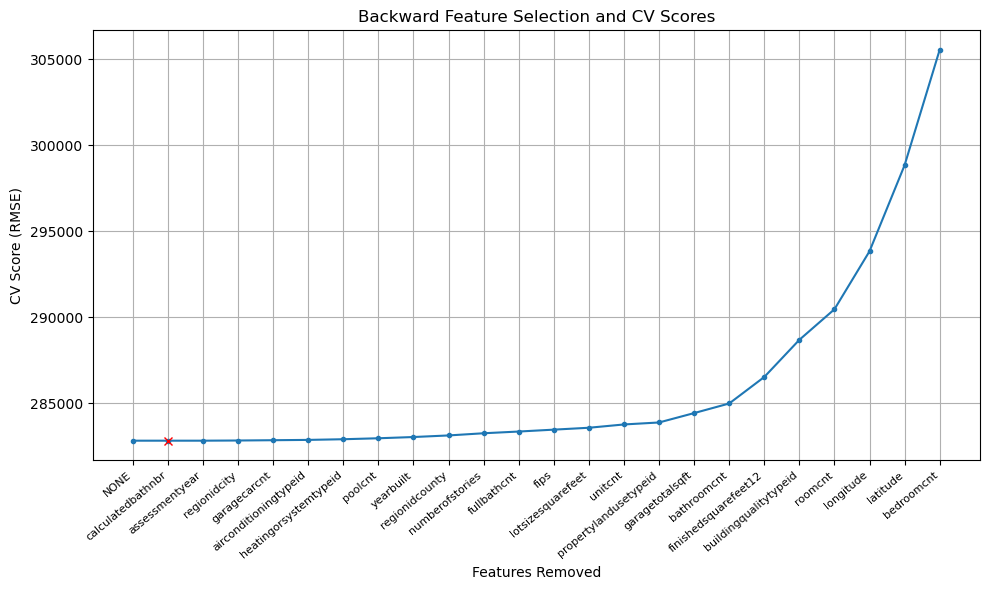

RESULTS FOR BACKWARD SELECTION
Best Features: ['airconditioningtypeid', 'bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid', 'calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'fips', 'fullbathcnt', 'garagecarcnt', 'garagetotalsqft', 'heatingorsystemtypeid', 'latitude', 'longitude', 'lotsizesquarefeet', 'poolcnt', 'propertylandusetypeid', 'regionidcity', 'regionidcounty', 'roomcnt', 'unitcnt', 'yearbuilt', 'numberofstories', 'assessmentyear']
Best CV Score (RMSE): $282,821.81


In [44]:
# Convert scores to Root MSE
best_scores_RMSE_backward = np.sqrt(best_scores_backward)
best_score_RMSE_backward = np.sqrt(best_score_backward)

plt.figure(figsize=(10, 6))
plt.title('Backward Feature Selection and CV Scores')
plt.plot(range(1, len(best_scores_RMSE_backward) + 1), best_scores_RMSE_backward, marker='.')
index = np.argmin(best_scores_RMSE_backward) 
plt.plot([index + 1], best_scores_RMSE_backward[index], marker='x', color='red')  
plt.xticks(range(1, len(selected_features_backward) + 1), selected_features_backward, rotation=40, ha='right', fontsize=8)
plt.xlabel('Features Removed')
plt.ylabel('CV Score (RMSE)')
plt.grid()
plt.tight_layout()
plt.show()

# Print the best subset and score
print("RESULTS FOR BACKWARD SELECTION")
print(f"Best Features: {best_feature_set_backward}")
print(f"Best CV Score (RMSE): ${best_score_RMSE_backward:,.2f}")

#### **4.A Discussion:**  Describe in a paragraph what you see in the feature relationships and correlations.

Pay particular attention to especially interesting and/or strongly correlated feature relationships. 
 How do the different methods for seeing relationships compare? Do they agree or disagree?



The correlation matrix helped confirm this by showing strong positive relationships between the target and features like square footage (calculatedfinishedsquarefeet, finishedsquarefeet12), bathroom count, and room count. Geographic features like latitude and longitude also showed moderate correlations, which supports the idea that location matters.
The F-statistic plot further reinforced these findings by ranking finishedsquarefeet12 and calculatedfinishedsquarefeet at the top, indicating they explain a large amount of variance in the target. Features like garagecarcnt, buildingqualitytypeid, and yearbuilt also had notable F-scores, confirming their importance even if they weren’t the most strongly correlated linearly.
After running both forward and backward feature selection, I found that the results were consistent — both methods selected the same 11 features. This consistency gives 
confidence that these features are strong predictors of taxvaluedollarcnt. The model clearly favors size, location, and age as key drivers of property value, which aligns with what we expect in real estate. Features like bathroomcnt, bedroomcnt, calculatedfinishedsquarefeet, and yearbuilt appeared repeatedly as important.

Overall, the different methods of analysis — correlation, F-statistic, and sequential feature selection — largely agreed. Each offered a slightly different view: correlation showed raw pairwise relationships, F-statistic highlighted variance explained, and feature selection tested how well features worked together in a predictive model. Taken together, they point to a consistent set of core features that are most useful for modeling tax value.

### Part 4.B:  2-Dimensional Visualizations for Interesting Patterns  
   - Select three (3) pairs of features that exhibit meaningful relationships based on your previous analysis. 
   - Create 2D scatter plots or density plots to explore interactions between these features.  
   - Provide brief interpretations of any observed patterns or trends. 

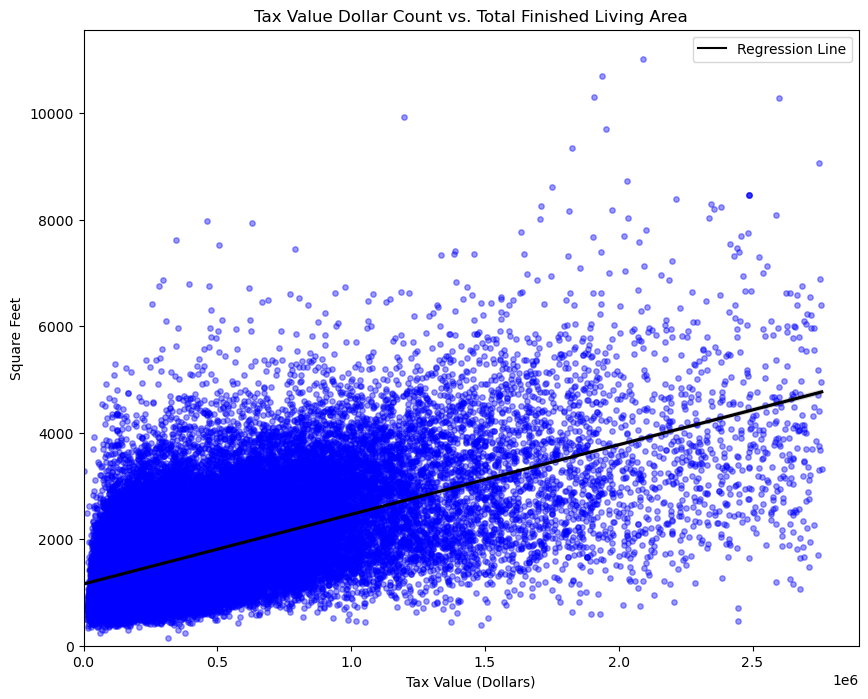

In [45]:
# Tax Value Dollar Count vs. Total Finished Living Area
plt.figure(figsize=(10,8))
sns.regplot(data=df_imputed, x='taxvaluedollarcnt', y='calculatedfinishedsquarefeet', 
            scatter_kws={'s': 15, 'alpha': 0.4, 'edgecolor': (0, 0, 1.0, 0.3), 'facecolors': (0, 0, 1.0, 0.2)}, 
            line_kws={'color': 'black'})
plt.plot([], [], color='black', label='Regression Line')
plt.title("Tax Value Dollar Count vs. Total Finished Living Area")
plt.xlabel("Tax Value (Dollars)")
plt.ylabel("Square Feet")
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.legend()
plt.show()

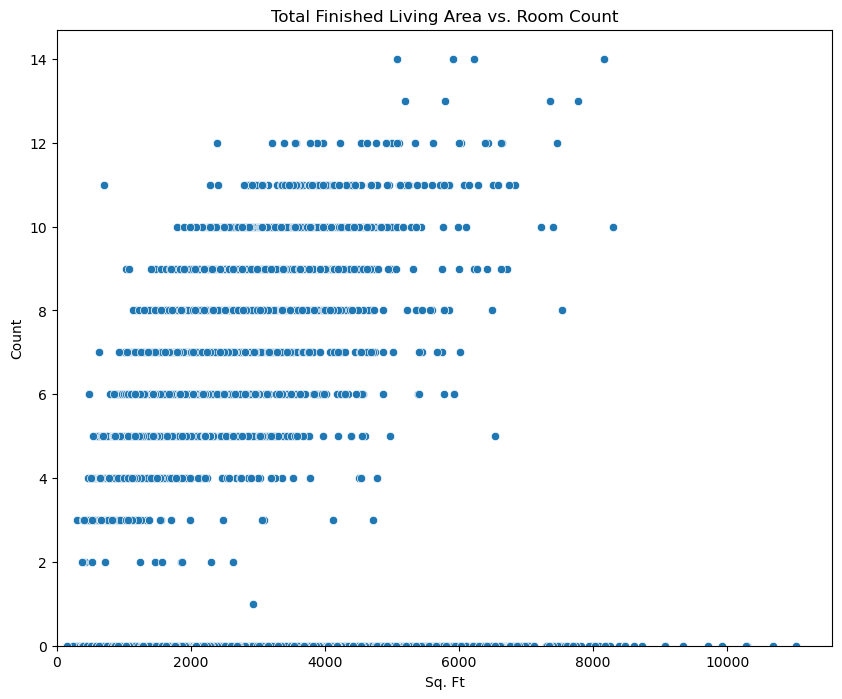

In [46]:
# Finished Living Room Area vs. Room Count
plt.figure(figsize=(10,8))
sns.scatterplot(data=df_imputed, x='calculatedfinishedsquarefeet', y='roomcnt')
plt.title("Total Finished Living Area vs. Room Count")
plt.xlabel("Sq. Ft")
plt.ylabel("Count")
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.show()

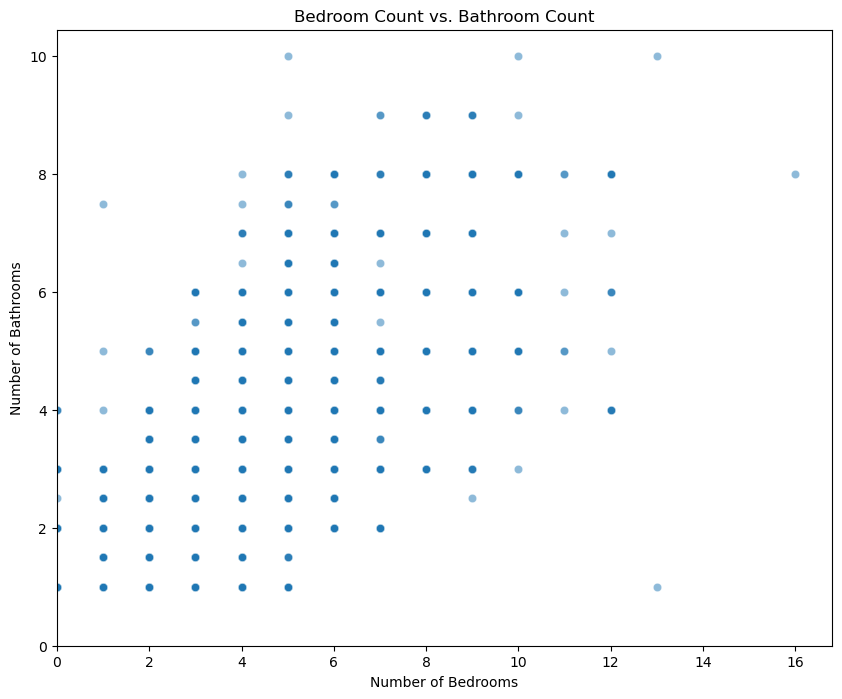

In [47]:
# Bedrooms vs Bathrooms
plt.figure(figsize=(10,8))
sns.scatterplot(data=df_imputed, x='bedroomcnt', y='bathroomcnt', alpha=0.5)
plt.title("Bedroom Count vs. Bathroom Count")
plt.xlabel("Number of Bedrooms")
plt.ylabel("Number of Bathrooms")
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.show()

#### **4.B Discussion:** Provide brief interpretations of any observed patterns or trends.


Tax Value Dollar Count vs. Total Finished Living Area: 
The scatter plot shows a clear positive trend between total finished living area square footage and tax value, which supports the idea that larger homes are generally assessed at higher values. While the overall pattern is upward, there's increasing variance at higher square footage levels — suggesting that other factors, like location or home quality, also influence value. A few extreme outliers are present, indicating ultra-large or high-value homes, but the bulk of the data supports square footage as a strong predictor of tax value.

Finished Living Room Area vs. Room Count:
The scatterplot of finished living room area versus the room count showed a positive correlation, which suggests that as the square footage increases, the number of rooms increases. This scatterplot also shows many houses with 0 room count with varying values for square footage. At first, this looked like a mistake, but after careful consideration, this might suggest that many of these houses are studios which makes sense with some of the other features like garage count and pool count being so sparse. 

Bedroom vs Bathroom: 
The scatterplot shows a generally positive relationship between bedroom and bathroom count, with most properties clustering around 2–5 bedrooms and 1–4 bathrooms. This suggests that as homes increase in size, they tend to include more bathrooms, which is expected in residential real estate. However, there is some variation, including outliers with more bathrooms than bedrooms or properties with a high number of rooms overall — likely indicating custom, luxury, or multi-unit properties.

## Part 5:  Feature Engineering: Investigate various transformations to better expose the underlying data patterns to machine learning algorithms. [6 pts]

**Important Notes:**  
- This last part is a bit open ended, since there is a huge variety of feature engineering techniques, most of which won't be useful for your particular dataset. 
- Understand that you can't evaluate the final usefulness of these transformations
until you choose a model, and  models may respond differently to various transformations or obviate some transformations (e.g., ensemble methods already do feature selection). 
- Therefore, write your transformations as functions or otherwise be prepared
to choose later on which transformations may be necessary. 

**Investigate feature engineering, where appropriate:**

- Feature scaling: standardize or normalize features as necessary
- Decompose features (e.g., categorical into One-Hot feature sequence, date/time into two features data and time, etc.).
- Add promising transformations of features
    - Exponential $\exp(x_i)$ or logarithmic $\log(x_j)$
    - Polynomial features  ( $x_i^2$, $x_i - x_j$), products ($x_i*x_j$), or ratios ($x_i/x_j$)

**ToDo:**
- Pick at least three transformations to try.
- Try each one and evaluate its effect using correlations or F-scores or a feature selection algorithm.
- Answer the discussion question. 

In [48]:
df_engineered = df_features.copy()

In [49]:
df_engineered['log_lot_size'] = np.log(df_engineered['lotsizesquarefeet'])

In [50]:
df_engineered['bed_bath'] = df_engineered['bathroomcnt'] * df_engineered['bedroomcnt']

In [51]:
df_engineered['ratio_lat_log'] = df_engineered['latitude'] / df_engineered['longitude']

In [52]:
# Evaluate effects of F-scores
X_new = df_engineered
y_new = df_target

f_scores, p_values = f_regression(X_new, y_new)
f_result = pd.Series(f_scores, index=X_new.columns).sort_values(ascending=False)

print("Top new features based on F-statistic:")
print(f_result.head(10))

Top new features based on F-statistic:
finishedsquarefeet12            40397.096092
calculatedfinishedsquarefeet    38625.617452
calculatedbathnbr               23619.792985
bathroomcnt                     23619.792985
fullbathcnt                     20965.458396
bed_bath                        15702.392030
buildingqualitytypeid            7061.096547
bedroomcnt                       5962.291699
ratio_lat_log                    2715.321494
garagetotalsqft                  2275.741193
dtype: float64


In [53]:
# Train, Test, and Split data
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(df_engineered, df_target, test_size=0.2, random_state=42)

# Define model
engineered_model_forward = LinearRegression()

# Run forward feature selection algorithm
selected_features_forward_2, best_scores_forward_2, best_feature_set_forward_2, best_score_forward_2 = forward_feature_selection(X_train_2, y_train_2, engineered_model_forward)

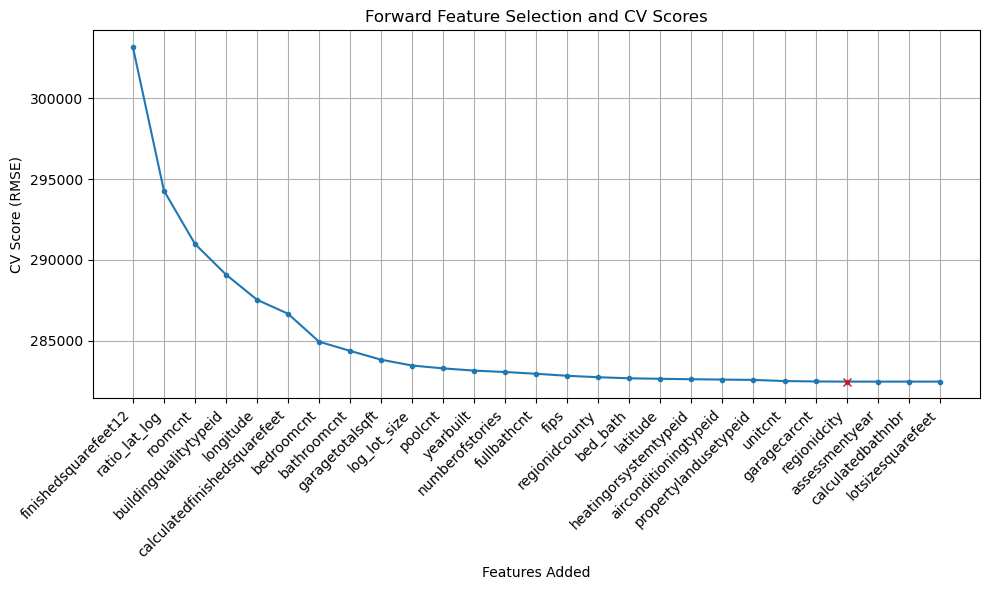

RESULTS FOR FORWARD SELECTION
Best Features: ['finishedsquarefeet12', 'ratio_lat_log', 'roomcnt', 'buildingqualitytypeid', 'longitude', 'calculatedfinishedsquarefeet', 'bedroomcnt', 'bathroomcnt', 'garagetotalsqft', 'log_lot_size', 'poolcnt', 'yearbuilt', 'numberofstories', 'fullbathcnt', 'fips', 'regionidcounty', 'bed_bath', 'latitude', 'heatingorsystemtypeid', 'airconditioningtypeid', 'propertylandusetypeid', 'unitcnt', 'garagecarcnt', 'regionidcity']
Best CV Score (RMSE): $282,485.36


In [54]:
# Convert scores to Root MSE
best_scores_RMSE_forward_2 = np.sqrt(best_scores_forward_2)
best_score_RMSE_forward_2 = np.sqrt(best_score_forward_2)

# Plot the results
index = np.argmax(np.array(selected_features_forward_2) == best_feature_set_forward_2[-1])

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(best_scores_RMSE_forward_2) + 1), best_scores_RMSE_forward_2, marker='.')
plt.plot([index+1],best_score_RMSE_forward_2, marker='x', color='red')
plt.xticks(range(1, len(selected_features_forward_2) + 1), selected_features_forward_2, rotation=45, ha='right')
plt.title('Forward Feature Selection and CV Scores')
plt.xlabel('Features Added')
plt.ylabel('CV Score (RMSE)')
plt.grid()
plt.tight_layout()
plt.show()

# Print the best subset and score
print("RESULTS FOR FORWARD SELECTION")
print(f"Best Features: {best_feature_set_forward_2}")
print(f"Best CV Score (RMSE): ${best_score_RMSE_forward_2:,.2f}")

#### **5 Discussion:** Describe in a paragraph why you chose these transformations and what you observed. 


We chose to apply a log transformation to lot size square footage and create interactive terms between bedroomcnt and bathroomcnt and between longitude and latitude. The log transformation was performed to help address the right-skewed distribution of home sizes, but did not appear to make a large difference in the feature selection algorithm or F-statistic. We also created bed_bath_product to capture the combined effect of bedroom and bathroom counts, since homes with more rooms often scale in complexity and value. This feature also ranked highly, outperforming both bedroom count and building quality individually. The ratio between latitude and longitude was the most interesting because the foward feature selection ranked it as the number 2 best feature above both counterparts individually. The goal of this transformation was to capture both effects of these two features as one number because alone longitude and latitude are not as meaningful. These transformations helped uncover relationships that are not immediately visible in the raw features and may enhance model performance.

## **Appendix 1: Features of the Zillow Dataset**  

0. **parcelid**: Unique identifier for the property parcel.  
1. **airconditioningtypeid**: Identifier for the type of air conditioning installed.  
2. **architecturalstyletypeid**: Identifier for the architectural style of the property.  
3. **basementsqft**: Square footage of the basement.  
4. **bathroomcnt**: Number of bathrooms.  
5. **bedroomcnt**: Number of bedrooms.  
6. **buildingclasstypeid**: Identifier for the building framing type (e.g., wood frame, steel frame).  
7. **buildingqualitytypeid**: Numeric value indicating the quality of the building (higher values often indicate better quality).  
8. **calculatedbathnbr**: Calculated number of bathrooms, including fractional bathrooms.  
9. **decktypeid**: Identifier for the type of deck.  
10. **finishedfloor1squarefeet**: Square footage of the finished area on the first floor.  
11. **calculatedfinishedsquarefeet**: Total finished living area square footage.  
12. **finishedsquarefeet12**: Finished living area square footage.  
13. **finishedsquarefeet13**: Perimeter living area square footage.  
14. **finishedsquarefeet15**: Total area.  
15. **finishedsquarefeet50**: Square footage of the finished area on the upper floors.  
16. **finishedsquarefeet6**: Base unfinished and finished area square footage.  
17. **fips**: Federal Information Processing Standards code, uniquely identifying counties and county equivalents.  
18. **fireplacecnt**: Number of fireplaces.  
19. **fullbathcnt**: Number of full bathrooms.  
20. **garagecarcnt**: Number of cars that can fit in the garage.  
21. **garagetotalsqft**: Total square footage of the garage.  
22. **hashottuborspa**: Indicates if the property has a hot tub or spa.  
23. **heatingorsystemtypeid**: Identifier for the type of heating system.  
24. **latitude**: Latitude coordinate of the property.  
25. **longitude**: Longitude coordinate of the property.  
26. **lotsizesquarefeet**: Lot size in square feet.  
27. **poolcnt**: Number of pools on the property.  
28. **poolsizesum**: Total square footage of all pools.  
29. **pooltypeid10**: Identifier for spa or hot tub.  
30. **pooltypeid2**: Identifier for pool with spa or hot tub.  
31. **pooltypeid7**: Identifier for pool without hot tub or spa.  
32. **propertycountylandusecode**: County land use code for the property.  
33. **propertylandusetypeid**: Identifier for the property land use type.  
34. **propertyzoningdesc**: Description of the property's zoning.  
35. **rawcensustractandblock**: Unprocessed census tract and block identifier.  
36. **regionidcity**: Identifier for the city.  
37. **regionidcounty**: Identifier for the county.  
38. **regionidneighborhood**: Identifier for the neighborhood.  
39. **regionidzip**: Identifier for the ZIP code.  
40. **roomcnt**: Total number of rooms.  
41. **storytypeid**: Identifier for the type of stories in the building (e.g., basement, attic).  
42. **threequarterbathnbr**: Number of 3/4 bathrooms (typically includes a shower but no tub).  
43. **typeconstructiontypeid**: Identifier for the type of construction (e.g., frame, masonry).  
44. **unitcnt**: Number of units in the building (e.g., for multi-family properties).  
45. **yardbuildingsqft17**: Square footage of the 17th yard building (e.g., shed).  
46. **yardbuildingsqft26**: Square footage of the 26th yard building.  
47. **yearbuilt**: Year the property was built.  
48. **numberofstories**: Number of stories in the building.  
49. **fireplaceflag**: Indicates if the property has a fireplace.  
50. **assessmentyear**: Year the property was assessed.  
51. **taxdelinquencyflag**: Indicates whether the property’s taxes are delinquent. Often “Y” if taxes are past due; otherwise null/empty.  
52. **taxdelinquencyyear**: The year in which the property’s taxes became delinquent.  
53. **censustractandblock**: A combined identifier for the property’s census tract and block group (part of the U.S. Census geographic hierarchy).  
54. **taxvaluedollarcnt**: Total assessed value of the property (land plus structure) in dollars.  


## Appendix 2: Summary of Basic Imputation Methods
Imputation depends on the data type and context. Below are common techniques for handling missing values.

---

### **1. Simple Imputation (Basic Methods)**
| Method | Best For | Code Example | Pros | Cons |
|--------|---------|--------------|------|------|
| **Drop Missing Values** | Few missing values (<5% of data) | `df.dropna()` | Quick and easy | Can remove valuable data |
| **Mean Imputation** | Normally distributed numerical data | `df.fillna(df.mean())` | Preserves mean; simple | Distorts variance, weak for skewed data |
| **Median Imputation** | Skewed numerical data | `df.fillna(df.median())` | Robust to outliers | May not capture patterns |
| **Mode Imputation** | Categorical features | `df.fillna(df.mode().iloc[0])` | Keeps most common category | Can introduce bias |
| **Constant Value (e.g., 0)** | Special cases (e.g., unknown numerical data) | `df.fillna(0)` | Simple and interpretable | Can mislead model |
| **"Unknown" Category Imputation** (**New Addition**) | Categorical features with missing values | `df.fillna('Unknown')` | Keeps all rows, prevents data loss | May introduce artificial category |

---

### **2. Statistical & Advanced Imputation**
| Method | Best For | Code Example | Pros | Cons |
|--------|---------|--------------|------|------|
| **Interpolation** | Time series, ordered data | `df.interpolate(method='linear')` | Preserves trends | May not work for non-continuous data |
| **K-Nearest Neighbors (KNN)** | Small datasets, patterns in features | `KNNImputer(n_neighbors=5).fit_transform(df)` | Uses similar observations | Computationally expensive |
| **Multivariate Imputation (MICE)** | Complex relationships between variables | `IterativeImputer().fit_transform(df)` | Captures relationships | Slower than mean/median |
| **Regression Imputation** | When missing values depend on other variables | Train regression model to predict missing values | More accurate than mean/median | Risk of overfitting |

---

### **When to Use "Unknown" Category for Categorical Imputation**
✅ **Good for:**
- Categorical features where missing values may indicate meaningful differences.  
- Customer data (e.g., missing survey responses → "No Response").  
- Product categories where missing could be a separate group.  

❌ **Avoid if:**
- The missing category does **not** have a meaningful interpretation.
- The model might learn spurious patterns from an artificial category.

---

### **Which Method to Choose?**
| Scenario | Best Method |
|----------|------------|
| **Few missing values (<5%)** | Drop NaNs (`df.dropna()`) |
| **Numerical & normal distribution** | Mean (`df.fillna(df.mean())`) |
| **Numerical & skewed distribution** | Median (`df.fillna(df.median())`) |
| **Categorical features** | Mode (`df.fillna(df.mode().iloc[0])`) |
| **Categorical with possible meaning in missingness** | "Unknown" Category (`df.fillna('Unknown')`) |
| **Small dataset with patterns** | KNN Imputer (`KNNImputer()`) |
| **Complex relationships between features** | MICE / Iterative Imputer |

